In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import zipfile
import wandb
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm.notebook import tqdm

from matplotlib import colors as mcolors
import matplotlib.gridspec as gridspec
from IPython.display import HTML, display
import time
import torch.optim as optim

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
!curl https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar --output dakshana.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1915M  100 1915M    0     0  39.1M      0  0:00:48  0:00:48 --:--:-- 40.0M


In [4]:
!tar -xvf '/kaggle/working/dakshana.tar'

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

In [5]:
# Download and prepare the Dakshina dataset
def download_and_prepare_dataset(language='hi'):
    """
    Download and extract the Dakshina dataset for the specified language.
    Default language is Hindi (hi).
    """

    print(f"Dataset prepared for language: {language}")
    return f'/kaggle/working/dakshina_dataset_v1.0/{language}/lexicons/'

In [6]:
# Load the dataset
def load_dataset(data_path, split, lang = 'hi'):
    """
    Load the dataset for the specified split (train, dev, test).
    """
    file_path = os.path.join(data_path, f"{lang}.translit.sampled.{split}.tsv")
    df = pd.read_csv(file_path, sep='\t', header=None)

    # The romanized text is in column 0, and the native script is in column 1
    romanized = df[0].astype(str).tolist()
    native = df[1].astype(str).tolist()

    return romanized, native

In [7]:
# Vocabulary class to handle character-level tokenization
class Vocab:
    def __init__(self):
        # Special tokens
        self.PAD_token = 0  # Padding token
        self.SOS_token = 1  # Start of sequence token
        self.EOS_token = 2  # End of sequence token

        # Initialize vocabulary dictionaries
        self.char2idx = {'<PAD>': self.PAD_token, '<SOS>': self.SOS_token, '<EOS>': self.EOS_token}
        self.idx2char = {self.PAD_token: '<PAD>', self.SOS_token: '<SOS>', self.EOS_token: '<EOS>'}
        self.char_count = {}
        self.n_chars = 3  # Start with PAD, SOS, EOS

    def add_word(self, word):
        """
        Add all characters in a word to the vocabulary.
        """
        for char in word:
            self.add_char(char)

    def add_char(self, char):
        """
        Add a character to the vocabulary if it doesn't exist.
        """
        if char not in self.char2idx:
            self.char2idx[char] = self.n_chars
            self.char_count[char] = 1
            self.idx2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char_count[char] += 1

    def __len__(self):
        return self.n_chars

In [8]:
# Create vocabularies from the training data
def create_vocabs(romanized_train, native_train):
    """
    Create vocabulary objects for both romanized and native scripts.
    """
    input_vocab = Vocab()
    output_vocab = Vocab()

    for word in romanized_train:
        input_vocab.add_word(word)

    for word in native_train:
        output_vocab.add_word(word)

    return input_vocab, output_vocab

In [9]:
# Custom dataset class
class TransliterationDataset(Dataset):
    def __init__(self, romanized, native, input_vocab, output_vocab):
        self.romanized = romanized
        self.native = native
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab

    def __len__(self):
        return len(self.romanized)

    def __getitem__(self, idx):
        romanized_word = self.romanized[idx]
        native_word = self.native[idx]

        # Convert characters to indices
        input_indices = [self.input_vocab.char2idx[char] for char in romanized_word]
        # Add EOS token
        input_indices.append(self.input_vocab.EOS_token)

        output_indices = [self.output_vocab.SOS_token]  # Start with SOS token
        output_indices.extend([self.output_vocab.char2idx[char] for char in native_word])
        output_indices.append(self.output_vocab.EOS_token)  # End with EOS token

        return {
            'input': torch.tensor(input_indices, dtype=torch.long),
            'output': torch.tensor(output_indices, dtype=torch.long),
            'input_len': len(input_indices),
            'output_len': len(output_indices),
            'romanized': romanized_word,
            'native': native_word
        }

In [10]:
# Collate function for batching
def collate_fn(batch):
    # Sort by input length in descending order
    batch.sort(key=lambda x: x['input_len'], reverse=True)

    # Get max lengths
    max_input_len = max([item['input_len'] for item in batch])
    max_output_len = max([item['output_len'] for item in batch])

    # Prepare tensors
    input_tensor = torch.zeros(len(batch), max_input_len, dtype=torch.long)
    output_tensor = torch.zeros(len(batch), max_output_len, dtype=torch.long)
    input_lengths = []
    output_lengths = []
    romanized = []
    native = []

    # Fill tensors
    for i, item in enumerate(batch):
        input_len = item['input_len']
        output_len = item['output_len']

        input_tensor[i, :input_len] = item['input']
        output_tensor[i, :output_len] = item['output']

        input_lengths.append(input_len)
        output_lengths.append(output_len)
        romanized.append(item['romanized'])
        native.append(item['native'])

    return {
        'input': input_tensor.to(device),
        'output': output_tensor.to(device),
        'input_lengths': torch.tensor(input_lengths, dtype=torch.long).to(device),
        'output_lengths': torch.tensor(output_lengths, dtype=torch.long).to(device),
        'romanized': romanized,
        'native': native
    }


In [11]:
# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers=1, dropout=0, cell_type='LSTM'):
        super(Encoder, self).__init__()

        self.input_size = input_size  # Size of the input vocabulary
        self.embed_size = embed_size  # Size of the embeddings
        self.hidden_size = hidden_size  # Size of the hidden state
        self.num_layers = num_layers  # Number of RNN layers
        self.dropout = dropout  # Dropout rate
        self.cell_type = cell_type  # RNN cell type: 'RNN', 'LSTM', 'GRU'

        # Embedding layer
        self.embedding = nn.Embedding(input_size, embed_size)

        # Choose RNN cell type
        if cell_type == 'RNN':
            self.rnn = nn.RNN(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:
            raise ValueError("cell_type must be one of ['RNN', 'LSTM', 'GRU']")

        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, x_lengths):
        """
        x: Input tensor of shape (batch_size, seq_len)
        x_lengths: Lengths of input sequences
        """
        # Apply embedding
        embedded = self.dropout_layer(self.embedding(x))  # (batch_size, seq_len, embed_size)

        # Pack padded sequence for efficient computation
        packed = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths.cpu(), batch_first=True)

        # Pass through RNN
        outputs, hidden = self.rnn(packed)

        # Unpack padded sequence
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        return outputs, hidden

In [12]:
# Decoder class
class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers=1, dropout=0, cell_type='LSTM'):
        super(Decoder, self).__init__()

        self.output_size = output_size  # Size of the output vocabulary
        self.embed_size = embed_size  # Size of the embeddings
        self.hidden_size = hidden_size  # Size of the hidden state
        self.num_layers = num_layers  # Number of RNN layers
        self.dropout = dropout  # Dropout rate
        self.cell_type = cell_type  # RNN cell type: 'RNN', 'LSTM', 'GRU'

        # Embedding layer
        self.embedding = nn.Embedding(output_size, embed_size)

        # Choose RNN cell type
        if cell_type == 'RNN':
            self.rnn = nn.RNN(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:
            raise ValueError("cell_type must be one of ['RNN', 'LSTM', 'GRU']")

        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, hidden):
        """
        x: Input tensor of shape (batch_size, 1)
        hidden: Hidden state from the encoder
        """
        # Apply embedding
        x = self.dropout_layer(self.embedding(x))  # (batch_size, 1, embed_size)

        # Pass through RNN
        output, hidden = self.rnn(x, hidden)

        # Apply output layer
        prediction = self.fc_out(output.squeeze(1))  # (batch_size, output_size)

        return prediction, hidden

In [13]:
# Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Ensure encoder and decoder have the same hidden size and RNN type
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.cell_type == decoder.cell_type, \
            "Encoder and decoder must use the same RNN cell type!"

        # Add a projection layer if encoder and decoder have different numbers of layers
        self.encoder_layers = encoder.num_layers
        self.decoder_layers = decoder.num_layers

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        """
        src: Source tensor of shape (batch_size, src_len)
        src_lengths: Lengths of source sequences
        trg: Target tensor of shape (batch_size, trg_len)
        teacher_forcing_ratio: Probability to use teacher forcing
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        # Initialize a tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode the source sequence
        encoder_outputs, hidden = self.encoder(src, src_lengths)

        # Adjust hidden states if encoder and decoder have different numbers of layers
        if self.encoder_layers != self.decoder_layers:
            if self.encoder.cell_type == 'LSTM':
                # For LSTM, hidden is a tuple of (hidden state, cell state)
                hidden_state, cell_state = hidden
                
                # Select appropriate layers or repeat as needed
                if self.encoder_layers > self.decoder_layers:
                    # Take just what we need (top layers)
                    hidden = (hidden_state[-self.decoder_layers:], 
                             cell_state[-self.decoder_layers:])
                else:
                    # Repeat the last layer to match decoder layers
                    hidden_state = hidden_state.repeat(self.decoder_layers, 1, 1)
                    cell_state = cell_state.repeat(self.decoder_layers, 1, 1)
                    hidden = (hidden_state, cell_state)
            else:
                # For RNN/GRU, hidden is just the hidden state
                if self.encoder_layers > self.decoder_layers:
                    # Take just what we need (top layers)
                    hidden = hidden[-self.decoder_layers:]
                else:
                    # Repeat the last layer to match decoder layers
                    hidden = hidden.repeat(self.decoder_layers, 1, 1)

        # First input to the decoder is the <SOS> token
        input = trg[:, 0].unsqueeze(1)  # (batch_size, 1)

        for t in range(1, trg_len):
            # Pass through decoder
            output, hidden = self.decoder(input, hidden)

            # Store output
            outputs[:, t] = output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1).unsqueeze(1)

            # Use either the prediction or the ground truth
            input = trg[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

In [14]:
# Seq2Seq model with attention
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttention, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        # Ensure encoder and decoder have the same hidden size and RNN type
        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.cell_type == decoder.cell_type, \
            "Encoder and decoder must use the same RNN cell type!"

    def forward(self, src, src_lengths, trg, teacher_forcing_ratio=0.5):
        """
        src: Source tensor of shape (batch_size, src_len)
        src_lengths: Lengths of source sequences
        trg: Target tensor of shape (batch_size, trg_len)
        teacher_forcing_ratio: Probability to use teacher forcing
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_size

        # Initialize a tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src.shape[1]).to(self.device)

        # Encode the source sequence
        encoder_outputs, hidden = self.encoder(src, src_lengths)

        # First input to the decoder is the <SOS> token
        input = trg[:, 0].unsqueeze(1)  # (batch_size, 1)

        for t in range(1, trg_len):
            # Pass through decoder
            output, hidden, attn_weights = self.decoder(input, hidden, encoder_outputs)

            # Store output and attention weights
            outputs[:, t] = output
            attentions[:, t] = attn_weights.squeeze(1)

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1).unsqueeze(1)

            # Use either the prediction or the ground truth
            input = trg[:, t].unsqueeze(1) if teacher_force else top1

        return outputs, attentions

In [15]:
# Training function
def train(model, dataloader, optimizer, criterion, clip, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0

    for batch in tqdm(dataloader):
        # Get batch data
        src = batch['input']
        trg = batch['output']
        src_lengths = batch['input_lengths']

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        if isinstance(model, Seq2SeqAttention):
            output, _ = model(src, src_lengths, trg, teacher_forcing_ratio)
        else:
            output = model(src, src_lengths, trg, teacher_forcing_ratio)

        # Remove SOS token from targets (we're predicting from the second token onward)
        trg = trg[:, 1:]
        output = output[:, 1:].reshape(-1, output.shape[2])
        trg = trg.reshape(-1)

        # Calculate loss
        loss = criterion(output, trg)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [16]:
# Validation function
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Get batch data
            src = batch['input']
            trg = batch['output']
            src_lengths = batch['input_lengths']

            # Forward pass
            if isinstance(model, Seq2SeqAttention):
                output, _ = model(src, src_lengths, trg, 0)  # No teacher forcing
            else:
                output = model(src, src_lengths, trg, 0)  # No teacher forcing

            # Remove SOS token from targets (we're predicting from the second token onward)
            trg = trg[:, 1:]
            output = output[:, 1:].reshape(-1, output.shape[2])
            trg = trg.reshape(-1)

            # Calculate loss
            loss = criterion(output, trg)

            # Update epoch loss
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [17]:
# Function to convert indices to string
def indices_to_string(indices, vocab):
    """
    Convert a list of indices to the corresponding string.
    """
    chars = []
    for idx in indices:
        if idx == vocab.EOS_token:
            break
        elif idx != vocab.SOS_token:
            chars.append(vocab.idx2char[idx])

    return ''.join(chars)

In [18]:
# Character-level accuracy
def calculate_char_level_accuracy(predictions, targets):
    """
    Calculate the character-level accuracy between predictions and targets.
    """
    total_chars = 0
    correct_chars = 0

    for pred, tgt in zip(predictions, targets):
        # Calculate character-level edit distance
        distance = 0
        for p, t in zip(pred, tgt):
            if p == t:
                correct_chars += 1
            total_chars += 1

        # Add remaining characters if lengths are different
        if len(pred) != len(tgt):
            total_chars += abs(len(pred) - len(tgt))

    return correct_chars / total_chars if total_chars > 0 else 0

In [19]:
# Word-level accuracy
def calculate_word_level_accuracy(predictions, targets):
    """
    Calculate the word-level accuracy between predictions and targets.
    """
    correct_words = sum(1 for pred, tgt in zip(predictions, targets) if pred == tgt)
    total_words = len(predictions)

    return correct_words / total_words if total_words > 0 else 0

In [20]:
# Modified test_model function to handle different numbers of layers
def test_model(model, dataloader, output_vocab, beam_size=1):
    model.eval()
    all_predictions = []
    all_targets = []
    all_inputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Get batch data
            src = batch['input']
            src_lengths = batch['input_lengths']
            native = batch['native']
            romanized = batch['romanized']

            # Perform beam search decoding
            if beam_size > 1:
                predictions = beam_search_decode(model, src, src_lengths, output_vocab, beam_size=beam_size)
            else:
                # Greedy decoding
                if isinstance(model, Seq2SeqAttention):
                    # Initialize with SOS tokens
                    sos_tokens = torch.tensor([[output_vocab.SOS_token]] * src.size(0), device=device)
                    encoder_outputs, hidden = model.encoder(src, src_lengths)
                    
                    # Handle different numbers of layers between encoder and decoder
                    if model.encoder_layers != model.decoder_layers:
                        if model.encoder.cell_type == 'LSTM':
                            # For LSTM, hidden is a tuple of (hidden state, cell state)
                            hidden_state, cell_state = hidden
                            
                            if model.encoder_layers > model.decoder_layers:
                                # Take just what we need (top layers)
                                hidden = (hidden_state[-model.decoder_layers:], 
                                         cell_state[-model.decoder_layers:])
                            else:
                                # Repeat the last layer to match decoder layers
                                hidden_state = hidden_state.repeat(model.decoder_layers, 1, 1)
                                cell_state = cell_state.repeat(model.decoder_layers, 1, 1)
                                hidden = (hidden_state, cell_state)
                        else:
                            # For RNN/GRU, hidden is just the hidden state
                            if model.encoder_layers > model.decoder_layers:
                                hidden = hidden[-model.decoder_layers:]
                            else:
                                hidden = hidden.repeat(model.decoder_layers, 1, 1)

                    # Initialize predictions tensor
                    max_length = 100
                    predictions_tensor = torch.zeros(src.size(0), max_length, dtype=torch.long, device=device)
                    predictions_tensor[:, 0] = output_vocab.SOS_token

                    # Decode step by step
                    for t in range(1, max_length):
                        # Get input for current timestep
                        curr_input = predictions_tensor[:, t-1:t]

                        # Pass through decoder
                        output, hidden, _ = model.decoder(curr_input, hidden, encoder_outputs)

                        # Get most likely next token
                        predictions_tensor[:, t] = output.argmax(1)

                        # Check if all sequences have reached EOS
                        if (predictions_tensor[:, t] == output_vocab.EOS_token).all():
                            break
                else:
                    # Regular Seq2Seq model
                    sos_tokens = torch.tensor([[output_vocab.SOS_token]] * src.size(0), device=device)
                    encoder_outputs, hidden = model.encoder(src, src_lengths)
                    
                    # Handle different numbers of layers between encoder and decoder
                    if model.encoder_layers != model.decoder_layers:
                        if model.encoder.cell_type == 'LSTM':
                            # For LSTM, hidden is a tuple of (hidden state, cell state)
                            hidden_state, cell_state = hidden
                            
                            if model.encoder_layers > model.decoder_layers:
                                # Take just what we need (top layers)
                                hidden = (hidden_state[-model.decoder_layers:], 
                                         cell_state[-model.decoder_layers:])
                            else:
                                # Repeat the last layer to match decoder layers
                                hidden_state = hidden_state.repeat(model.decoder_layers, 1, 1)
                                cell_state = cell_state.repeat(model.decoder_layers, 1, 1)
                                hidden = (hidden_state, cell_state)
                        else:
                            # For RNN/GRU, hidden is just the hidden state
                            if model.encoder_layers > model.decoder_layers:
                                hidden = hidden[-model.decoder_layers:]
                            else:
                                hidden = hidden.repeat(model.decoder_layers, 1, 1)

                    # Initialize predictions tensor
                    max_length = 100
                    predictions_tensor = torch.zeros(src.size(0), max_length, dtype=torch.long, device=device)
                    predictions_tensor[:, 0] = output_vocab.SOS_token

                    # Decode step by step
                    for t in range(1, max_length):
                        # Get input for current timestep
                        curr_input = predictions_tensor[:, t-1:t]

                        # Pass through decoder
                        output, hidden = model.decoder(curr_input, hidden)

                        # Get most likely next token
                        predictions_tensor[:, t] = output.argmax(1)

                        # Check if all sequences have reached EOS
                        if (predictions_tensor[:, t] == output_vocab.EOS_token).all():
                            break

                # Convert tensors to lists of indices
                predictions = []
                for i in range(src.size(0)):
                    # Extract tokens until EOS or end of sequence
                    pred_indices = []
                    for t in range(1, predictions_tensor.size(1)):  # Skip SOS token
                        token = predictions_tensor[i, t].item()
                        if token == output_vocab.EOS_token:
                            break
                        pred_indices.append(token)
                    predictions.append(pred_indices)

            # Convert predictions and targets to strings
            for i, (pred, tgt, inp) in enumerate(zip(predictions, native, romanized)):
                pred_str = indices_to_string(pred, output_vocab)
                all_predictions.append(pred_str)
                all_targets.append(tgt)
                all_inputs.append(inp)

    # Calculate accuracy metrics
    char_level_accuracy = calculate_char_level_accuracy(all_predictions, all_targets)
    word_level_accuracy = calculate_word_level_accuracy(all_predictions, all_targets)

    return all_predictions, all_targets, all_inputs, char_level_accuracy, word_level_accuracy

In [21]:
# Attention Decoder class
class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers=1, dropout=0, cell_type='LSTM'):
        super(AttentionDecoder, self).__init__()

        self.output_size = output_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.cell_type = cell_type

        # Embedding layer
        self.embedding = nn.Embedding(output_size, embed_size)

        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, hidden_size)
        self.attention_combine = nn.Linear(hidden_size + embed_size, embed_size)

        # Choose RNN cell type
        if cell_type == 'RNN':
            self.rnn = nn.RNN(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(
                embed_size,
                hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:
            raise ValueError("cell_type must be one of ['RNN', 'LSTM', 'GRU']")

        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)

        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, hidden, encoder_outputs):
        """
        x: Input tensor of shape (batch_size, 1)
        hidden: Hidden state from the encoder
        encoder_outputs: Outputs from the encoder of shape (batch_size, src_len, hidden_size)
        """
        # Apply embedding
        embedded = self.dropout_layer(self.embedding(x))  # (batch_size, 1, embed_size)

        # Calculate attention weights
        if self.cell_type == 'LSTM':
            attn_weights = F.softmax(
                torch.bmm(encoder_outputs, hidden[0][-1].unsqueeze(2)).squeeze(2),
                dim=1
            ).unsqueeze(1)
        else:
            attn_weights = F.softmax(
                torch.bmm(encoder_outputs, hidden[-1].unsqueeze(2)).squeeze(2),
                dim=1
            ).unsqueeze(1)

        # Apply attention weights to encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch_size, 1, hidden_size)

        # Combine embedded input and attention context vector
        attn_combined = self.attention_combine(
            torch.cat((embedded.squeeze(1), context.squeeze(1)), dim=1)
        ).unsqueeze(1)

        # Pass through RNN
        output, hidden = self.rnn(attn_combined, hidden)

        # Apply output layer
        prediction = self.fc_out(output.squeeze(1))  # (batch_size, output_size)

        return prediction, hidden, attn_weights

In [22]:
# Beam Search for Seq2Seq model
def beam_search_decode(model, src, src_lengths, output_vocab, max_length=100, beam_size=3):
    """
    Perform beam search decoding for a Seq2Seq model.
    """
    model.eval()
    batch_size = src.shape[0]
    
    # Store results for all items in the batch
    results = []
    
    with torch.no_grad():
        # Process each item in the batch separately
        for b in range(batch_size):
            # Get single item from batch
            src_item = src[b:b+1]  # Keep batch dimension
            src_length_item = src_lengths[b:b+1]
            
            # Encode the source sequence
            encoder_outputs, hidden = model.encoder(src_item, src_length_item)

            # Handle different numbers of layers between encoder and decoder
            if hasattr(model, 'encoder_layers') and hasattr(model, 'decoder_layers'):
                if model.encoder_layers != model.decoder_layers:
                    if model.encoder.cell_type == 'LSTM':
                        # For LSTM, hidden is a tuple of (hidden state, cell state)
                        hidden_state, cell_state = hidden
                        
                        if model.encoder_layers > model.decoder_layers:
                            # Take just what we need (top layers)
                            hidden = (hidden_state[-model.decoder_layers:], 
                                     cell_state[-model.decoder_layers:])
                        else:
                            # Repeat the last layer to match decoder layers
                            hidden_state = hidden_state.repeat(model.decoder_layers, 1, 1)
                            cell_state = cell_state.repeat(model.decoder_layers, 1, 1)
                            hidden = (hidden_state, cell_state)
                    else:
                        # For RNN/GRU, hidden is just the hidden state
                        if model.encoder_layers > model.decoder_layers:
                            hidden = hidden[-model.decoder_layers:]
                        else:
                            hidden = hidden.repeat(model.decoder_layers, 1, 1)
            
            # Initialize beam with SOS token
            sos_token = output_vocab.SOS_token
            eos_token = output_vocab.EOS_token
            
            # Initialize beams: (sequence, score, hidden_state)
            beams = [(torch.tensor([[sos_token]], device=device), 0.0, hidden)]
            completed_beams = []
            
            # Beam search
            for _ in range(max_length):
                if len(beams) == 0:
                    break
                    
                candidates = []
                for seq, score, h in beams:
                    if seq[0, -1].item() == eos_token:
                        # If sequence ends with EOS, add to completed beams
                        completed_beams.append((seq, score, h))
                        continue
                    
                    # Pass the last token through the decoder
                    last_token = seq[0, -1:].unsqueeze(0)
                    
                    if isinstance(model.decoder, AttentionDecoder):
                        # Using attention decoder
                        output, new_h, _ = model.decoder(last_token, h, encoder_outputs)
                    else:
                        # Using regular decoder
                        output, new_h = model.decoder(last_token, h)
                    
                    # Get log probabilities
                    log_probs = F.log_softmax(output, dim=1)
                    
                    # Get top k candidates
                    topk_probs, topk_idx = log_probs.topk(beam_size)
                    
                    for i in range(beam_size):
                        prob = topk_probs[0, i].item()
                        idx = topk_idx[0, i].item()
                        
                        # Create new sequence by appending the token
                        new_seq = torch.cat([seq, torch.tensor([[idx]], device=device)], dim=1)
                        new_score = score + prob
                        
                        candidates.append((new_seq, new_score, new_h))
                
                # Select top k candidates as new beams
                beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
            
            # Add any remaining beams to completed beams
            completed_beams.extend(beams)
            
            # Select the best beam
            if completed_beams:
                best_seq = sorted(completed_beams, key=lambda x: x[1], reverse=True)[0][0]
            else:
                best_seq = beams[0][0] if beams else torch.tensor([[sos_token]], device=device)
            
            # Convert to list and remove SOS/EOS tokens
            seq_list = best_seq.squeeze(0).cpu().numpy().tolist()
            if seq_list[0] == sos_token:
                seq_list = seq_list[1:]
            if seq_list and seq_list[-1] == eos_token:
                seq_list = seq_list[:-1]
                
            results.append(seq_list)
    
    return results


In [23]:
# Create confusion matrix for character-level errors
def create_confusion_matrix(predictions, targets):
    """
    Create and plot a confusion matrix for character-level errors.
    """
    # Collect all unique characters
    all_chars = set()
    for pred, tgt in zip(predictions, targets):
        all_chars.update(pred)
        all_chars.update(tgt)

    all_chars = sorted(list(all_chars))
    char_to_idx = {char: i for i, char in enumerate(all_chars)}

    # Initialize confusion matrix
    confusion_matrix = np.zeros((len(all_chars), len(all_chars)))

    # Fill confusion matrix
    for pred, tgt in zip(predictions, targets):
        # Dynamic programming for minimum edit distance with operation tracking
        m, n = len(pred), len(tgt)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        operations = [[None] * (n + 1) for _ in range(m + 1)]

        # Base cases
        for i in range(m + 1):
            dp[i][0] = i
            if i > 0:
                operations[i][0] = ('delete', i-1, 0)

        for j in range(n + 1):
            dp[0][j] = j
            if j > 0:
                operations[0][j] = ('insert', 0, j-1)

        # Fill dp table
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if pred[i-1] == tgt[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                    operations[i][j] = ('match', i-1, j-1)
                else:
                    delete_cost = dp[i-1][j] + 1
                    insert_cost = dp[i][j-1] + 1
                    substitute_cost = dp[i-1][j-1] + 1

                    min_cost = min(delete_cost, insert_cost, substitute_cost)
                    dp[i][j] = min_cost

                    if min_cost == delete_cost:
                        operations[i][j] = ('delete', i-1, j)
                    elif min_cost == insert_cost:
                        operations[i][j] = ('insert', i, j-1)
                    else:
                        operations[i][j] = ('substitute', i-1, j-1)

        # Backtrack to find operations
        i, j = m, n
        while i > 0 or j > 0:
            op, prev_i, prev_j = operations[i][j]

            if op == 'substitute':
                pred_char = pred[prev_i]
                tgt_char = tgt[prev_j]
                pred_idx = char_to_idx[pred_char]
                tgt_idx = char_to_idx[tgt_char]
                confusion_matrix[tgt_idx][pred_idx] += 1

            i, j = prev_i, prev_j

    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(confusion_matrix, xticklabels=all_chars, yticklabels=all_chars,
                cmap='YlGnBu', annot=False, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Character Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    # wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})

# Question 1

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m004 (da24m004-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Dataset prepared for language: hi
Train set size: 44204
Dev set size: 4358
Test set size: 4502
Input vocabulary size: 66
Output vocabulary size: 29
Epoch 1/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.2310
Train Loss: 2.2629 | Valid Loss: 2.2310
Epoch 2/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.1833
Train Loss: 2.0764 | Valid Loss: 2.1833
Epoch 3/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.1353
Train Loss: 2.0199 | Valid Loss: 2.1353
Epoch 4/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.1291
Train Loss: 1.9697 | Valid Loss: 2.1291
Epoch 5/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.0758
Train Loss: 1.9235 | Valid Loss: 2.0758
Epoch 6/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 2.0119
Train Loss: 1.8901 | Valid Loss: 2.0119
Epoch 7/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train Loss: 1.8528 | Valid Loss: 2.0165
Epoch 8/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 1.9719
Train Loss: 1.8124 | Valid Loss: 1.9719
Epoch 9/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 1.9495
Train Loss: 1.7944 | Valid Loss: 1.9495
Epoch 10/10


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Saved best model with validation loss: 1.9233
Train Loss: 1.7536 | Valid Loss: 1.9233


  0%|          | 0/36 [00:00<?, ?it/s]

Character-level accuracy: 0.3658
Word-level accuracy: 0.0029

Examples:
Input: अपरिवर्तनशील
Predicted: aprshastra
Target: aparivartanshali

Input: अपरिवर्तनशील
Predicted: aprshastra
Target: aparivartansheel

Input: अपरिवर्तनशील
Predicted: aprshastra
Target: aparivartanshil

Input: अनीश्वरवादी
Predicted: anthaaaaaaa
Target: anishwarvadi

Input: अनीश्वरवादी
Predicted: anthaaaaaaa
Target: anishwarwadi

Input: अनुप्रयोगों
Predicted: anushaai
Target: anuprayogi

Input: अनुप्रयोगों
Predicted: anushaai
Target: anuprayogon

Input: अनुप्रयोगों
Predicted: anushaai
Target: anupryogon

Input: अकापुल्को
Predicted: alliaaa
Target: acapulco

Input: अकापुल्को
Predicted: alliaaa
Target: akapulko



epoch,▁▂▃▃▄▅▆▆▇█
test_char_accuracy,▁
test_word_accuracy,▁
train_loss,█▅▅▄▃▃▂▂▂▁
valid_loss,█▇▆▆▄▃▃▂▂▁
epoch,10
test_char_accuracy,0.36579
test_word_accuracy,0.00289
train_loss,1.75358
valid_loss,1.92325


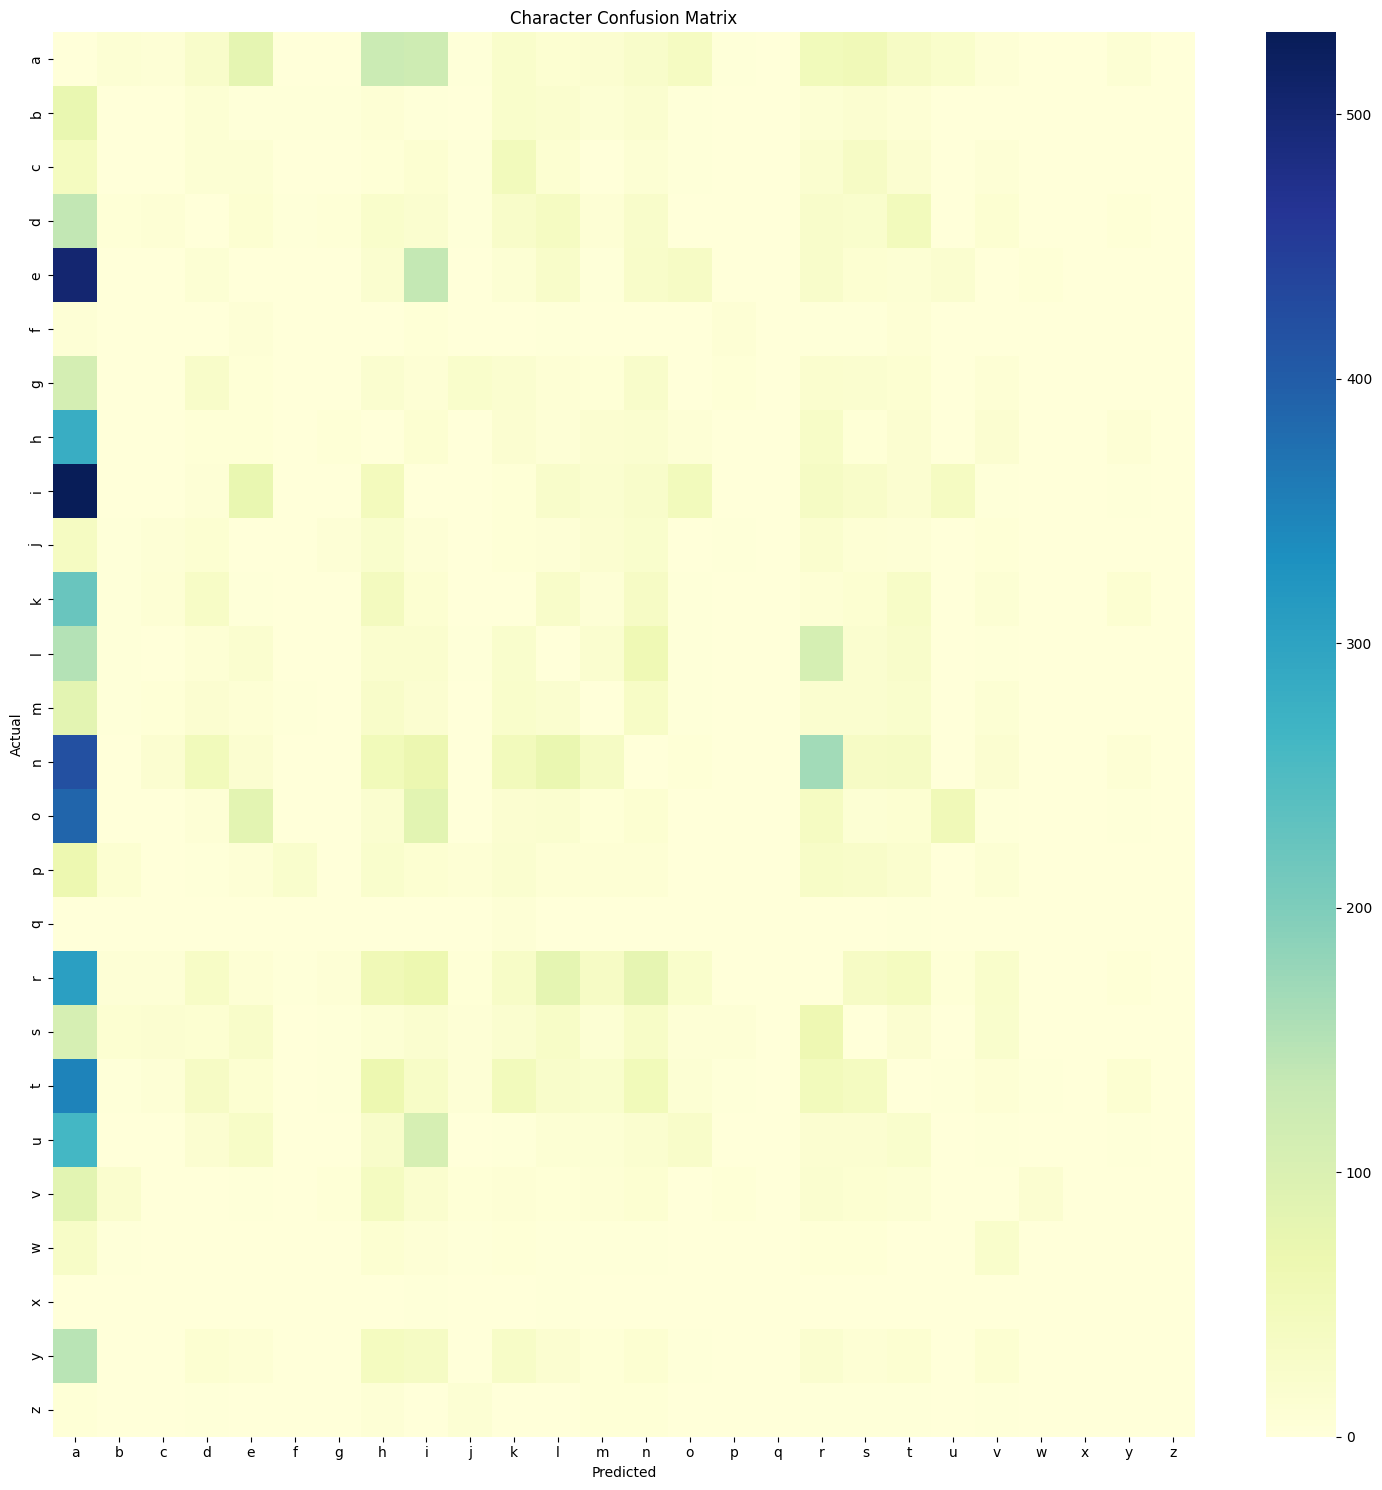

In [24]:
# os.environ["WANDB_API_KEY"] = "7040d84a3ed65a967eb3389dd6fe774b418576ed"
# wandb.login(key="7040d84a3ed65a967eb3389dd6fe774b418576ed")
wandb.init(project='hindi-transliteration_1', name='seq2seq-lstm-attention_Q1')

# Download and prepare the dataset
data_path = download_and_prepare_dataset(language='hi')

# Load the datasets
romanized_train, native_train = load_dataset(data_path, 'train')
romanized_dev, native_dev = load_dataset(data_path, 'dev')
romanized_test, native_test = load_dataset(data_path, 'test')

print(f"Train set size: {len(romanized_train)}")
print(f"Dev set size: {len(romanized_dev)}")
print(f"Test set size: {len(romanized_test)}")

# Create vocabularies
input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

print(f"Input vocabulary size: {len(input_vocab)}")
print(f"Output vocabulary size: {len(output_vocab)}")

# Create datasets
train_dataset = TransliterationDataset(romanized_train, native_train, input_vocab, output_vocab)
dev_dataset = TransliterationDataset(romanized_dev, native_dev, input_vocab, output_vocab)
test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

# Create dataloaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Model hyperparameters for Q1
input_size = len(input_vocab)
output_size = len(output_vocab)
embed_size = 256  # Character embedding size
hidden_size = 512  # Hidden layer size
num_layers = 1  # One layer for both encoder and decoder
dropout = 0.2
cell_type = 'RNN'  # Can be 'RNN', 'GRU', or 'LSTM'


learning_rate = 0.001
clip = 1.0

# Create the basic seq2seq model
encoder = Encoder(input_size, embed_size, hidden_size, num_layers, dropout, cell_type)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, dropout, cell_type)
model = Seq2Seq(encoder, decoder, device).to(device)

# Log model parameters to WandB
wandb.config.update({
    'input_size': input_size,
    'output_size': output_size,
    'embed_size': embed_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'learning_rate': learning_rate,
    'clip': clip,
    'cell_type': cell_type,
    'batch_size': batch_size
})

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab.PAD_token)

# Training loop
n_epochs = 10
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')

    # Train
    train_loss = train(model, train_dataloader, optimizer, criterion, clip, teacher_forcing_ratio=0.5)

    # Evaluate
    valid_loss = evaluate(model, dev_dataloader, criterion)

    # Log metrics to WandB
    wandb.log({
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'epoch': epoch+1
    })

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'Saved best model with validation loss: {valid_loss:.4f}')

    print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Test the model
predictions, targets, inputs, char_acc, word_acc = test_model(model, test_dataloader, output_vocab, beam_size=3)

# Log test metrics to WandB
wandb.log({
    'test_char_accuracy': char_acc,
    'test_word_accuracy': word_acc
})

print(f'Character-level accuracy: {char_acc:.4f}')
print(f'Word-level accuracy: {word_acc:.4f}')

# Print some examples
print('\nExamples:')
for i in range(min(10, len(predictions))):
    print(f'Input: {inputs[i]}')
    print(f'Predicted: {predictions[i]}')
    print(f'Target: {targets[i]}')
    print()

# Create confusion matrix for most common errors
create_confusion_matrix(predictions, targets)
wandb.finish()

# Question 2

In [28]:
def main():
    # Set up Weights & Biases
    run = wandb.init(project='hindi-transliteration_3', name=f'cell_{config.cell_type}_batch_{config.batch_size}_emb_{config.embed_size}_hid_{config.hidden_size}_enc_{config.num_layers_encoder}')
    config = run.config
    
    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')
    
    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_dev, native_dev = load_dataset(data_path, 'dev')
    
    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)
    
    # Create datasets
    train_dataset = TransliterationDataset(romanized_train, native_train, input_vocab, output_vocab)
    dev_dataset = TransliterationDataset(romanized_dev, native_dev, input_vocab, output_vocab)
    
    # Create dataloaders
    batch_size = config.batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    # Model hyperparameters from wandb sweep
    input_size = len(input_vocab)
    output_size = len(output_vocab)
    embed_size = config.embed_size
    hidden_size = config.hidden_size
    num_layers_encoder = config.num_layers_encoder
    num_layers_decoder = config.num_layers_decoder
    dropout = config.dropout
    cell_type = config.cell_type
    
    # Create models
    encoder = Encoder(input_size, embed_size, hidden_size, num_layers_encoder, dropout, cell_type)
    decoder = Decoder(output_size, embed_size, hidden_size, num_layers_decoder, dropout, cell_type)
    model = Seq2Seq(encoder, decoder, device).to(device)

    # Store the layer counts in the model for later use in the forward pass
    model.encoder_layers = num_layers_encoder
    model.decoder_layers = num_layers_decoder
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=output_vocab.PAD_token)
    
    # Training loop
    n_epochs = config.n_epochs
    best_valid_loss = float('inf')
    
    for epoch in range(n_epochs):
        # Train
        train_loss = train(model, train_dataloader, optimizer, criterion, config.clip, 
                           teacher_forcing_ratio=config.teacher_forcing_ratio)
        
        # Evaluate
        valid_loss = evaluate(model, dev_dataloader, criterion)
        
        # Log metrics to WandB
        wandb.log({
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'epoch': epoch+1
        })
        
        # Save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pt')
    
    # Evaluate on validation set with best model
    model.load_state_dict(torch.load('best_model.pt'))
    predictions, targets, inputs, char_acc, word_acc = test_model(
        model, dev_dataloader, output_vocab, beam_size=config.beam_size)
    
    # Log final metrics to WandB
    wandb.log({
        'val_char_accuracy': char_acc,
        'val_word_accuracy': word_acc,
        'best_val_loss': best_valid_loss
    })

In [ ]:
wandb.login(key="86398b520e35649f62ef0fe78a5f8cec01b76d3f")

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_word_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embed_size': {
            'values': [16, 32, 64, 128, 256]
        },
        'hidden_size': {
            'values': [32, 64, 128, 256, 512]
        },
        'num_layers_encoder': {
            'values': [1, 2, 3]
        },
        'num_layers_decoder': {
            'values': [1, 2, 3]
        },
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'value' : 64
        },
        'n_epochs': {
            'value': 10
        },
        'clip': {
            'value': 1.0
        },
        'teacher_forcing_ratio': {
            'distribution': 'uniform',
            'min': 0.3,
            'max': 0.7
        },
        'beam_size': {
            'values': [1, 3, 5]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='hindi-transliteration_3')

# Run the sweep
wandb.agent(sweep_id, function=main, count=35)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m004 (da24m004-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: aeil7g7a
Sweep URL: https://wandb.ai/da24m004-iitmaana/hindi-transliteration_3/sweeps/aeil7g7a


wandb: Agent Starting Run: fhlue9fa with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.008307995040959056
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6309712635451665


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▂▂▁▃▁▂▁▁
best_val_loss,0.95125
epoch,10
train_loss,0.53536
val_char_accuracy,0.69558
val_word_accuracy,0.39055


wandb: Agent Starting Run: vwj7poaa with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0084312005737587
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.36344855027641015


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▄▃▃▃▂▂▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,▇▇▆▅▆█▅▆▃▁
best_val_loss,2.55848
epoch,10
train_loss,2.47345
val_char_accuracy,0.15031
val_word_accuracy,0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s0qkwp9l with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 32
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.008185660156732368
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 3
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.34162394280343283


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▁▁▂▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,▃▄▃▁█▅▇▅▂▄
best_val_loss,2.58131
epoch,10
train_loss,2.52212
val_char_accuracy,0.13681
val_word_accuracy,0


wandb: Agent Starting Run: cmk9bsmi with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.006798363771976982
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 2
wandb: 	teacher_forcing_ratio: 0.48405754115010696


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▃▂▂▂▂▂▂▁▁
best_val_loss,0.85806
epoch,10
train_loss,0.59149
val_char_accuracy,0.68201
val_word_accuracy,0.33777


wandb: Agent Starting Run: yacxbj5s with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 128
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0079126738022121
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 2
wandb: 	teacher_forcing_ratio: 0.5910340734809643


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▂▂▁▁▂▁▁
best_val_loss,0.948
epoch,10
train_loss,0.59592
val_char_accuracy,0.67294
val_word_accuracy,0.32905


wandb: Agent Starting Run: 75jtqdrf with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.007788828439349718
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6958743400918193


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▃▃▁▄▄▄▄▄
best_val_loss,0.95037
epoch,10
train_loss,0.47784
val_char_accuracy,0.68469
val_word_accuracy,0.35888


wandb: Agent Starting Run: a4o53r7z with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 16
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0063009503167619
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6981738719693329


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▄▂▂▂▁▁▁
best_val_loss,0.95178
epoch,10
train_loss,0.50474
val_char_accuracy,0.69722
val_word_accuracy,0.37747


wandb: Agent Starting Run: 6dmsrf52 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005745846182951348
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 3
wandb: 	teacher_forcing_ratio: 0.6359699005993258


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▃▂▂▂▁▁▂▂▂
best_val_loss,0.83466
epoch,10
train_loss,0.35363
val_char_accuracy,0.71889
val_word_accuracy,0.41464


wandb: Agent Starting Run: s7yc9b9i with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005464234345212473
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 2
wandb: 	teacher_forcing_ratio: 0.6730169974681636


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▃▂▁▁▂▁▁▂▁
best_val_loss,0.87267
epoch,10
train_loss,0.34022
val_char_accuracy,0.7246
val_word_accuracy,0.43369


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bcpqh3fm with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.006492219765950348
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 3
wandb: 	teacher_forcing_ratio: 0.64228613752372


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▂▂▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▆▅▃▃▂▁▁▁▁
best_val_loss,1.33088
epoch,10
train_loss,0.8418
val_char_accuracy,0.58003
val_word_accuracy,0.1877


wandb: Agent Starting Run: cq30o63h with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0002862952234261832
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6458350497144754


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▃▂▂▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▂▂▁▁▁▁▁
best_val_loss,0.88387
epoch,10
train_loss,0.51629
val_char_accuracy,0.70329
val_word_accuracy,0.39651


wandb: Agent Starting Run: gnb3rdt9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0007120813206873857
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 2
wandb: 	teacher_forcing_ratio: 0.6563588740631416


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▁▂▁▂▂▂▃▃
best_val_loss,0.90585
epoch,10
train_loss,0.35854
val_char_accuracy,0.7076
val_word_accuracy,0.40592


wandb: Agent Starting Run: 20m11s8n with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.000209533606149231
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 3
wandb: 	num_layers_encoder: 3
wandb: 	teacher_forcing_ratio: 0.6486403911243636


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▃▃▂▂▁▂▁▁▁
best_val_loss,0.85739
epoch,10
train_loss,0.37692
val_char_accuracy,0.71974
val_word_accuracy,0.4268


wandb: Agent Starting Run: 4c05eb2n with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.00038652450977769257
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 2
wandb: 	num_layers_encoder: 3
wandb: 	teacher_forcing_ratio: 0.6583581807834862


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▂▂▂▃▁▁▂
best_val_loss,0.88025
epoch,10
train_loss,0.32848
val_char_accuracy,0.71515
val_word_accuracy,0.4229


wandb: Agent Starting Run: 0sytp3lk with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0015124252613610385
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 3
wandb: 	num_layers_encoder: 2
wandb: 	teacher_forcing_ratio: 0.589026676405944


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

wandb: ERROR Run 0sytp3lk errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_35/74633457.py", line 54, in main
wandb: ERROR     train_loss = train(model, train_dataloader, optimizer, criterion, config.clip,
wandb: ERROR                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/tmp/ipykernel_35/535577516.py", line 19, in train
wandb: ERROR     output = model(src, src_lengths, trg, teacher_forcing_ratio)
wandb: ERROR              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
wandb: ERROR     return self._call_impl(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/d

Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▃▂▂▂▂▂▂▁
best_val_loss,0.84623
epoch,10
train_loss,0.56107
val_char_accuracy,0.699
val_word_accuracy,0.37724


wandb: Agent Starting Run: pxchyji1 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.007977293031391424
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6661093788429305


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▅▄▄▃▃▄▁▂
best_val_loss,1.12213
epoch,10
train_loss,0.86412
val_char_accuracy,0.61845
val_word_accuracy,0.25769


wandb: Agent Starting Run: 3ug7rvhz with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.00305851218853188
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6142655507855972


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▄▂▂▁▁▁▂▃
best_val_loss,0.8579
epoch,10
train_loss,0.41938
val_char_accuracy,0.71397
val_word_accuracy,0.41189


wandb: Agent Starting Run: 51i1ehaj with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0007764562550278747
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6403283328259087


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▃▃▂▂▁▁▂▁▂
best_val_loss,0.86662
epoch,10
train_loss,0.38244
val_char_accuracy,0.71497
val_word_accuracy,0.40913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ekzk05pl with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.4
wandb: 	embed_size: 128
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.006307836536801619
wandb: 	n_epochs: 10
wandb: 	num_layers_decoder: 1
wandb: 	num_layers_encoder: 1
wandb: 	teacher_forcing_ratio: 0.6378198778659928


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

# Question 4

In [39]:
# Download and prepare the dataset
data_path = download_and_prepare_dataset(language='hi')

# Load the datasets
romanized_train, native_train = load_dataset(data_path, 'train')
romanized_dev, native_dev = load_dataset(data_path, 'dev')

# Create vocabularies
input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

# Create datasets
train_dataset = TransliterationDataset(romanized_train, native_train, input_vocab, output_vocab)
dev_dataset = TransliterationDataset(romanized_dev, native_dev, input_vocab, output_vocab)

# Create dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Model hyperparameters from wandb sweep
input_size = len(input_vocab)
output_size = len(output_vocab)
embed_size = 64
hidden_size = 512
num_layers_encoder = 2
num_layers_decoder = 1
dropout = 0.2
cell_type = "LSTM"

# Create models
encoder = Encoder(input_size, embed_size, hidden_size, num_layers_encoder, dropout, cell_type)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers_decoder, dropout, cell_type)
model = Seq2Seq(encoder, decoder, device).to(device)

# Store the layer counts in the model for later use in the forward pass
model.encoder_layers = num_layers_encoder
model.decoder_layers = num_layers_decoder

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005464234345212473)
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab.PAD_token)

# Training loop
n_epochs = 10
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    # Train
    train_loss = train(model, train_dataloader, optimizer, criterion, 1, 
                       teacher_forcing_ratio=0.6730169974681636)
    
    # Evaluate
    valid_loss = evaluate(model, dev_dataloader, criterion)
    
    # Log metrics to WandB
    # wandb.log({
    #     'train_loss': train_loss,
    #     'valid_loss': valid_loss,
    #     'epoch': epoch+1
    # })
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

# Evaluate on validation set with best model
model.load_state_dict(torch.load('best_model.pt'))
predictions, targets, inputs, char_acc, word_acc = test_model(
    model, dev_dataloader, output_vocab, beam_size=5)

Dataset prepared for language: hi


100%|██████████| 69/69 [17:07<00:00, 14.89s/it]


In [43]:

def evaluate_best_model():
    """
    Evaluate the best Hindi transliteration model and visualize predictions.
    """
    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')

    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')

    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

    # Match the parameters to the saved model architecture
    # The error shows the saved model has encoder with 2 layers and decoder with 1 layer
    params = {
        'embed_size': 64,
        'hidden_size': 512,
        'num_layers_encoder': 2,  # Changed from 1 to 2 to match saved model
        'num_layers_decoder': 1,  # Changed from 2 to 1 to match saved model
        'cell_type': 'LSTM',
        'dropout': 0.2,
        'beam_size': 5
    }

    # Create model with the correct parameters
    input_size = len(input_vocab)
    output_size = len(output_vocab)

    encoder = Encoder(input_size, params['embed_size'], params['hidden_size'],
                     params['num_layers_encoder'], params['dropout'], params['cell_type'])
    decoder = Decoder(output_size, params['embed_size'], params['hidden_size'],
                     params['num_layers_decoder'], params['dropout'], params['cell_type'])
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Make sure model knows its own layer counts for forward pass handling
    model.encoder_layers = params['num_layers_encoder']
    model.decoder_layers = params['num_layers_decoder']

    # Load best model weights
    model.load_state_dict(torch.load('best_model.pt'))

    # Test the model
    predictions, targets, inputs, char_acc, word_acc = test_model(
        model, test_dataloader, output_vocab, beam_size=params['beam_size'])

    # Prepare data to write to CSV
    rows = list(zip(predictions, targets, inputs))

    # Write to CSV file
    with open('predictions_vanilla.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['predictions', 'targets', 'inputs', 'char_acc', 'word_acc'])
        # Write rows with char_acc and word_acc repeated for each row
        for row in rows:
            writer.writerow(list(row) + [char_acc, word_acc])

    print(f'Character-level accuracy: {char_acc:.4f}')
    print(f'Word-level accuracy: {word_acc:.4f}')

    # Print some example predictions
    num_examples = min(10, len(predictions))
    print("\nSample Predictions:")
    for i in range(num_examples):
        print(f"Example {i+1}:")
        print(f"  Input: {inputs[i]}")
        print(f"  Prediction: {predictions[i]}")
        print(f"  Target: {targets[i]}")
        print(f"  Match: {'✓' if predictions[i] == targets[i] else '✗'}")
        print()

    # Visualize sample predictions with proper font rendering
    visualize_predictions(predictions, targets, inputs, n_samples=10)

    return predictions, targets, inputs

def visualize_predictions(predictions, targets, inputs, n_samples=10):
    """
    Create a visual grid showing sample inputs, predictions, and targets.
    """
    # Select a random sample of examples
    n_samples = min(n_samples, len(predictions))
    indices = random.sample(range(len(predictions)), n_samples)
    
    # Create a table for displaying results
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 3*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Set column headers
    axes[0, 0].set_title('Input (Romanized)', fontweight='bold')
    axes[0, 1].set_title('Prediction (Devanagari)', fontweight='bold')
    axes[0, 2].set_title('Target (Devanagari)', fontweight='bold')
    
    # Fill the table with examples
    for i, idx in enumerate(indices):
        # Determine if prediction matches target
        is_correct = predictions[idx] == targets[idx]
        color = 'green' if is_correct else 'red'
        
        # Display input, prediction, and target
        axes[i, 0].text(0.5, 0.5, inputs[idx], ha='center', va='center', fontsize=14)
        axes[i, 1].text(0.5, 0.5, predictions[idx], ha='center', va='center', fontsize=14, color=color)
        axes[i, 2].text(0.5, 0.5, targets[idx], ha='center', va='center', fontsize=14)
        
        # Remove axes
        for j in range(3):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    # wandb.log({"prediction_samples": wandb.Image('prediction_samples.png')})
    plt.show()

# Call the function to evaluate
evaluate_best_model()

Dataset prepared for language: hi


  0%|          | 0/71 [00:00<?, ?it/s]


AttributeError: 'Seq2Seq' object has no attribute 'beam_search'

In [41]:
from matplotlib import font_manager as fm
import torch
import csv
from tqdm import tqdm

def setup_devanagari_font():
    """
    Download and setup the Noto Sans Devanagari font for proper Hindi text rendering.
    Returns a FontProperties object to use in matplotlib plots.
    """
    # Define target directory and font file path
    font_dir = os.path.expanduser("~/.fonts")
    os.makedirs(font_dir, exist_ok=True)
    font_file = os.path.join(font_dir, "NotoSansDevanagari.ttf")
    
    # Download and save the font if it doesn't exist
    if not os.path.exists(font_file):
        print("Downloading Noto Sans Devanagari font...")
        url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
        with requests.get(url) as resp:
            with open(font_file, "wb") as f:
                f.write(resp.content)
        
        # Clear cached fonts
        os.system("rm -rf ~/.cache/matplotlib")
    
    # Register the font
    fm.fontManager.addfont(font_file)
    hindi_font = fm.FontProperties(fname=font_file)
    
    return hindi_font

def test_model(model, dataloader, output_vocab, beam_size=1):
    """
    Test the transliteration model and return predictions.
    """
    model.eval()
    all_predictions = []
    all_targets = []
    all_inputs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Get batch data
            src = batch['input']
            src_lengths = batch['input_lengths']
            native = batch['native']
            romanized = batch['romanized']

            # Perform beam search decoding if beam_size > 1
            if beam_size > 1:
                predictions = beam_search_decode(model, src, src_lengths, output_vocab, beam_size=beam_size)
            else:
                # Greedy decoding
                encoder_outputs, hidden = model.encoder(src, src_lengths)

                # Handle different numbers of layers between encoder and decoder
                if model.encoder_layers != model.decoder_layers:
                    if model.encoder.cell_type == 'LSTM':
                        # For LSTM, hidden is a tuple of (hidden state, cell state)
                        hidden_state, cell_state = hidden

                        if model.encoder_layers > model.decoder_layers:
                            # Take just what we need (top layers)
                            hidden = (hidden_state[-model.decoder_layers:],
                                    cell_state[-model.decoder_layers:])
                        else:
                            # Repeat the last layer to match decoder layers
                            hidden_state = hidden_state.repeat(model.decoder_layers, 1, 1)
                            cell_state = cell_state.repeat(model.decoder_layers, 1, 1)
                            hidden = (hidden_state, cell_state)
                    else:
                        # For RNN/GRU, hidden is just the hidden state
                        if model.encoder_layers > model.decoder_layers:
                            hidden = hidden[-model.decoder_layers:]
                        else:
                            hidden = hidden.repeat(model.decoder_layers, 1, 1)

                # Initialize predictions tensor
                max_length = 100
                predictions_tensor = torch.zeros(src.size(0), max_length, dtype=torch.long, device=device)
                predictions_tensor[:, 0] = output_vocab.SOS_token

                # Decode step by step
                for t in range(1, max_length):
                    # Get input for current timestep
                    curr_input = predictions_tensor[:, t-1:t]

                    # Pass through decoder
                    output, hidden = model.decoder(curr_input, hidden)

                    # Get most likely next token
                    predictions_tensor[:, t] = output.argmax(1)

                    # Check if all sequences have reached EOS
                    if (predictions_tensor[:, t] == output_vocab.EOS_token).all():
                        break

                # Convert tensors to lists of indices
                predictions = []
                for i in range(src.size(0)):
                    # Extract tokens until EOS or end of sequence
                    pred_indices = []
                    for t in range(1, predictions_tensor.size(1)):  # Skip SOS token
                        token = predictions_tensor[i, t].item()
                        if token == output_vocab.EOS_token:
                            break
                        pred_indices.append(token)
                    predictions.append(pred_indices)

            # Convert predictions and targets to strings
            for i, (pred, tgt, inp) in enumerate(zip(predictions, native, romanized)):
                pred_str = indices_to_string(pred, output_vocab)
                all_predictions.append(pred_str)
                all_targets.append(tgt)
                all_inputs.append(inp)

    # Calculate accuracy metrics
    char_level_accuracy = calculate_char_level_accuracy(all_predictions, all_targets)
    word_level_accuracy = calculate_word_level_accuracy(all_predictions, all_targets)

    return all_predictions, all_targets, all_inputs, char_level_accuracy, word_level_accuracy

def visualize_predictions(predictions, targets, inputs, n_samples=10):
    """
    Create a visual grid showing sample inputs, predictions, and targets
    with proper Devanagari font support.
    """
    # Setup Devanagari font for proper rendering
    hindi_font = setup_devanagari_font()
    
    # Select a random sample of examples
    n_samples = min(n_samples, len(predictions))
    indices = random.sample(range(len(predictions)), n_samples)
    
    # Create a table for displaying results
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 3*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Set column headers
    axes[0, 0].set_title('Input (Romanized)', fontweight='bold', fontsize=14)
    axes[0, 1].set_title('Prediction (Devanagari)', fontweight='bold', fontsize=14)
    axes[0, 2].set_title('Target (Devanagari)', fontweight='bold', fontsize=14)
    
    # Fill the table with examples
    for i, idx in enumerate(indices):
        # Determine if prediction matches target
        is_correct = predictions[idx] == targets[idx]
        color = 'green' if is_correct else 'red'
        
        # Display input (Romanized)
        axes[i, 0].text(0.5, 0.5, inputs[idx], ha='center', va='center', fontsize=14)
        
        # Display prediction (Devanagari) with proper font
        axes[i, 1].text(0.5, 0.5, predictions[idx], ha='center', va='center', 
                       fontproperties=hindi_font, fontsize=14, color=color)
        
        # Display target (Devanagari) with proper font
        axes[i, 2].text(0.5, 0.5, targets[idx], ha='center', va='center', 
                       fontproperties=hindi_font, fontsize=14)
        
        # Remove axes
        for j in range(3):
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png', dpi=300, bbox_inches='tight')
    # Uncomment to log to wandb
    # wandb.log({"prediction_samples": wandb.Image('prediction_samples.png')})
    plt.show()

def evaluate_best_model():
    """
    Evaluate the best Hindi transliteration model and visualize predictions.
    """
    
    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')

    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')

    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

    # Load the best hyperparameters from your sweep
    best_params = {
        'embed_size': 64,
        'hidden_size': 512,
        'num_layers_encoder': 2,
        'num_layers_decoder': 1,
        'cell_type': 'LSTM',
        'dropout': 0.2,
        'beam_size': 5
    }

    # Create model with best parameters
    input_size = len(input_vocab)
    output_size = len(output_vocab)

    encoder = Encoder(input_size, best_params['embed_size'], best_params['hidden_size'],
                     best_params['num_layers_encoder'], best_params['dropout'], best_params['cell_type'])
    decoder = Decoder(output_size, best_params['embed_size'], best_params['hidden_size'],
                     best_params['num_layers_decoder'], best_params['dropout'], best_params['cell_type'])
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Store the layer counts in the model for later use
    model.encoder_layers = best_params['num_layers_encoder']
    model.decoder_layers = best_params['num_layers_decoder']

    # Load best model weights
    model.load_state_dict(torch.load('best_model.pt'))

    # Test the model
    predictions, targets, inputs, char_acc, word_acc = test_model(
        model, test_dataloader, output_vocab, beam_size=best_params['beam_size'])

    # Prepare data to write to CSV
    rows = list(zip(predictions, targets, inputs))

    # Write to CSV file
    with open('predictions_vanilla.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['predictions', 'targets', 'inputs', 'char_acc', 'word_acc'])
        # Write rows with char_acc and word_acc repeated for each row
        for row in rows:
            writer.writerow(list(row) + [char_acc, word_acc])

    print(f'Character-level accuracy: {char_acc:.4f}')
    print(f'Word-level accuracy: {word_acc:.4f}')

    # Print some example predictions
    num_examples = min(10, len(predictions))
    print("\nSample Predictions:")
    for i in range(num_examples):
        print(f"Example {i+1}:")
        print(f"  Input: {inputs[i]}")
        print(f"  Prediction: {predictions[i]}")
        print(f"  Target: {targets[i]}")
        print(f"  Match: {'✓' if predictions[i] == targets[i] else '✗'}")
        print()

    # Visualize sample predictions
    visualize_predictions(predictions, targets, inputs, n_samples=10)

    return predictions, targets, inputs

Dataset prepared for language: hi


100%|██████████| 71/71 [17:40<00:00, 14.94s/it]


Character-level accuracy: 0.7160
Word-level accuracy: 0.4243

Sample Predictions:
Example 1:
  Input: अकापुल्को
  Prediction: akapulko
  Target: acapulco
  Match: ✗

Example 2:
  Input: अकापुल्को
  Prediction: akapulko
  Target: akapulko
  Match: ✓

Example 3:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angraji
  Match: ✗

Example 4:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angreji
  Match: ✓

Example 5:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angrzi
  Match: ✗

Example 6:
  Input: अंतर्मुख
  Prediction: antarmukh
  Target: antarmukh
  Match: ✓

Example 7:
  Input: अंतर्मुख
  Prediction: antarmukh
  Target: antmurkh
  Match: ✗

Example 8:
  Input: अंतर्मुख
  Prediction: antarmukh
  Target: antrmukh
  Match: ✗

Example 9:
  Input: अंद्राबी
  Prediction: andrabi
  Target: andrabee
  Match: ✗

Example 10:
  Input: अंद्राबी
  Prediction: andrabi
  Target: andrabi
  Match: ✓



/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2349 (\N{DEVANAGARI LETTER BHA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/102137888.py:119: UserWarning: G

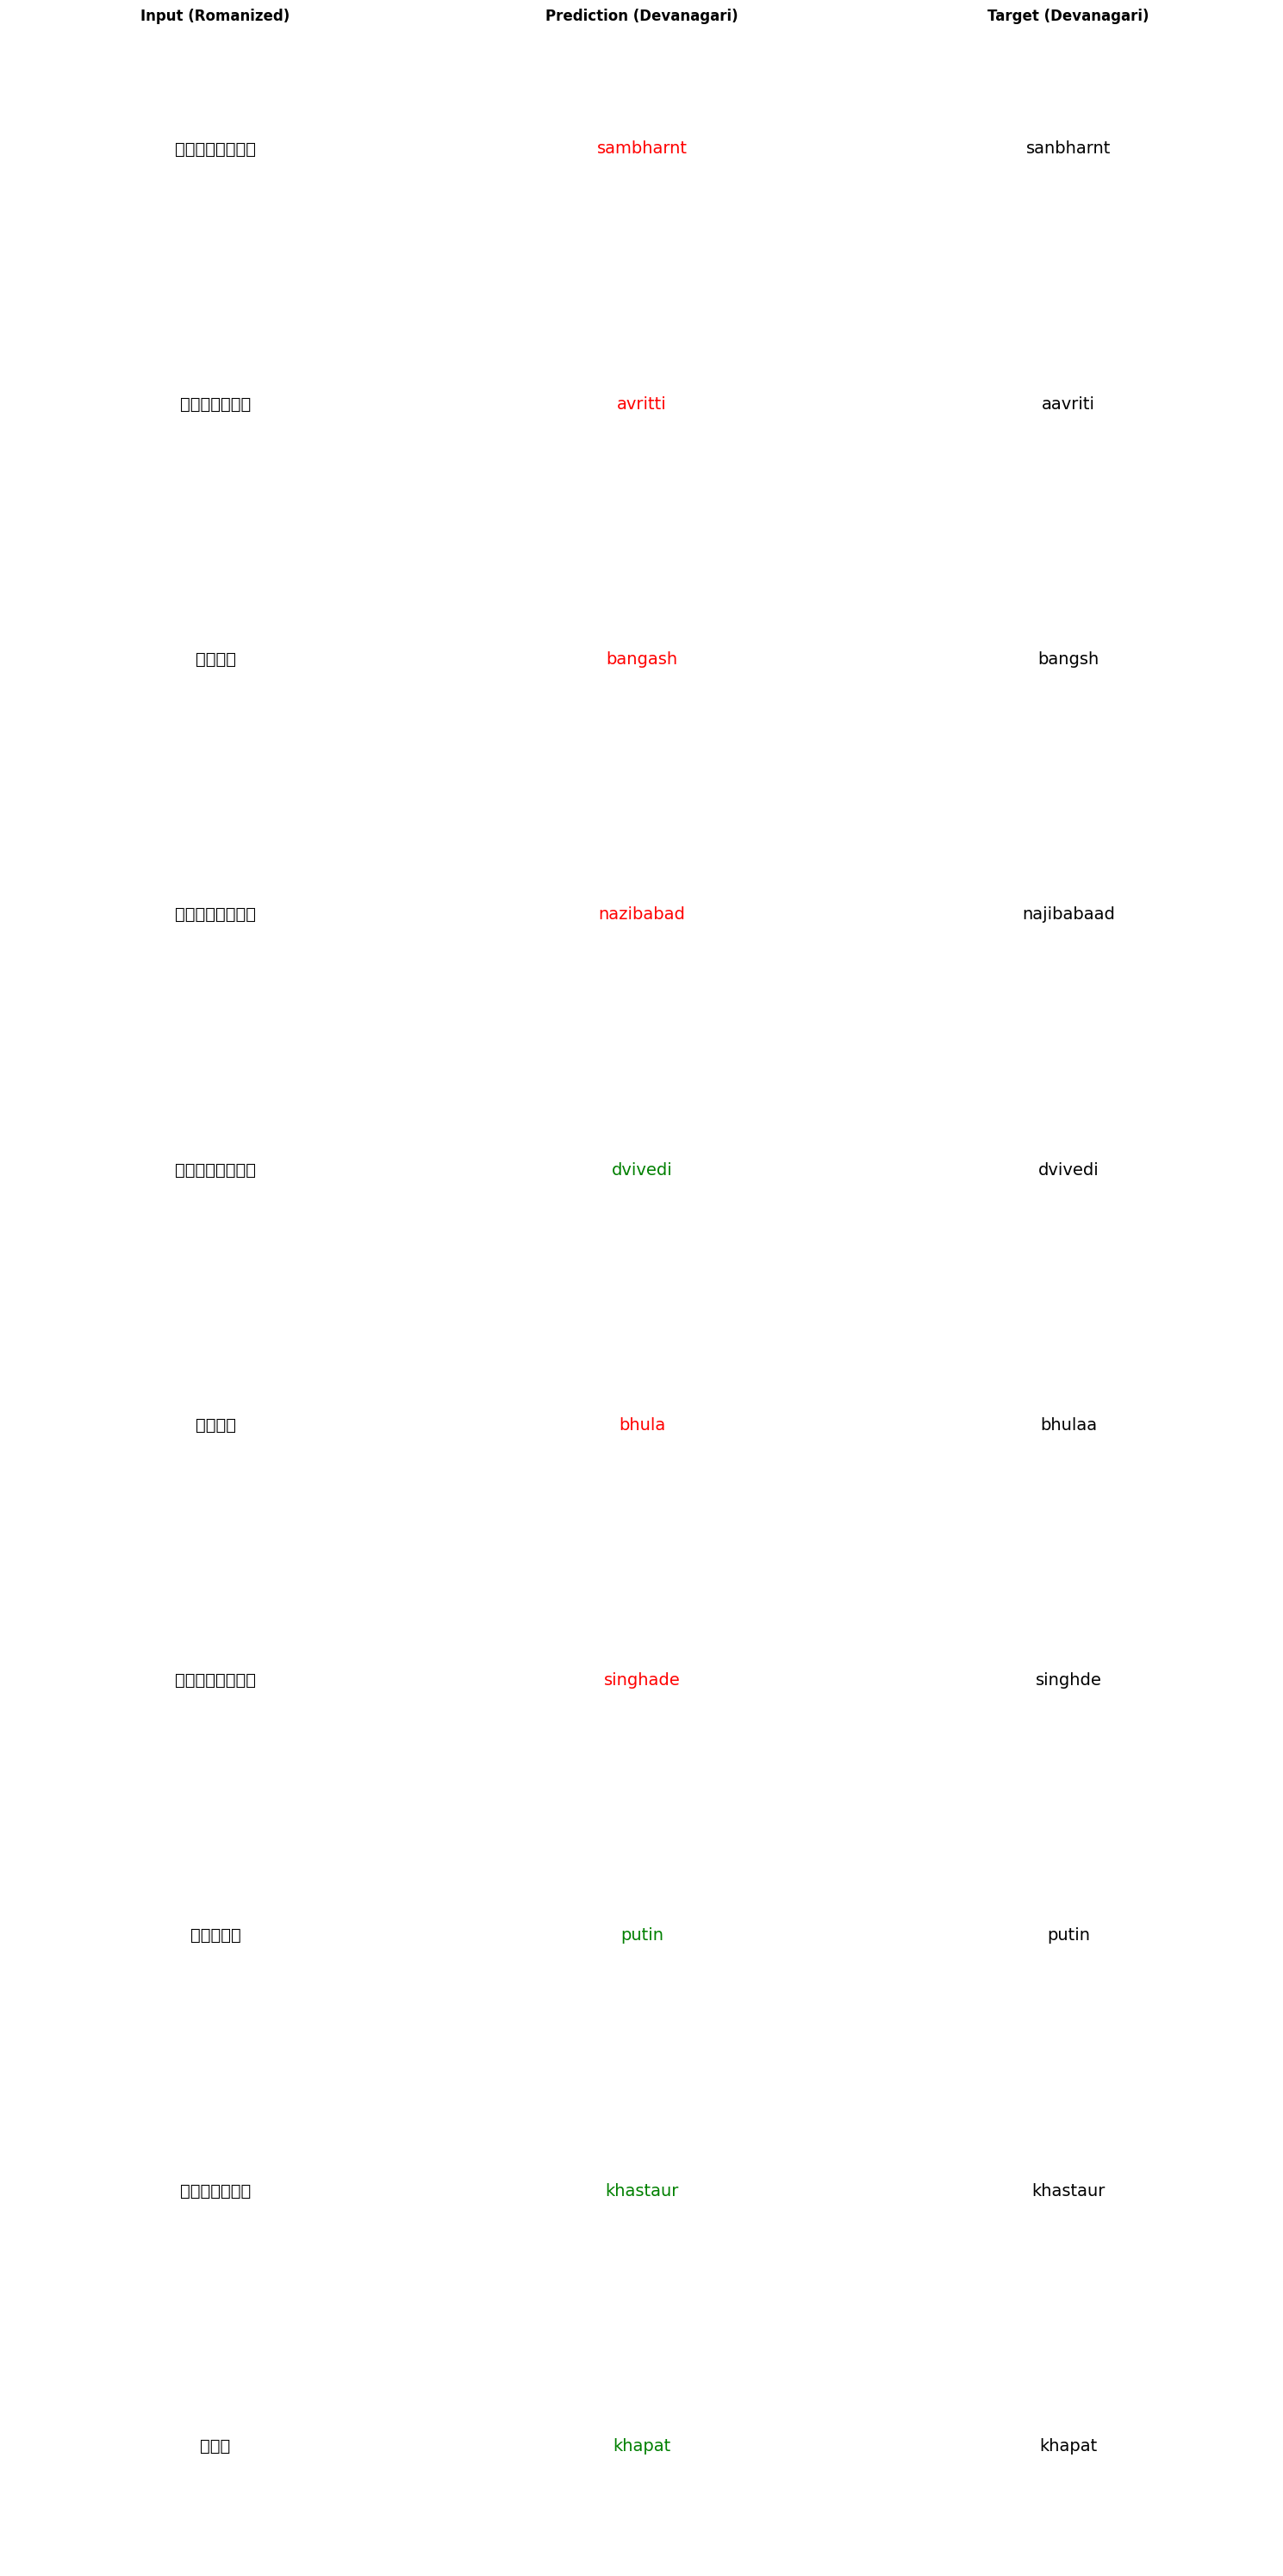

Data successfully saved to predictions_vanilla.csv


In [50]:
predictions, targets, inputs = evaluate_best_model()
filename='predictions_vanilla.csv'
# Prepare data to write to CSV
rows = list(zip(predictions, targets, inputs))

# Write to CSV file
with open(filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['predictions', 'targets', 'inputs'])
    # Write data rows
    for row in rows:
        writer.writerow(row)

print(f"Data successfully saved to {filename}")

# Question 5

In [28]:
def attention_model_sweep():
    # Set up Weights & Biases
    run = wandb.init(project='hindi-transliteration_5')
    config = run.config
    # Dynamically set run name based on key hyperparameters
    run_name = (f"cell-{config.cell_type}_"
                f"bs{config.batch_size}_"
                f"emb{config.embed_size}_"
                f"hid{config.hidden_size}_"
                f"lr{config.learning_rate:.0e}_"
                f"dr{config.dropout}")
    run.name = run_name
    run.save()  # Save the updated run name
    
    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')
    
    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_dev, native_dev = load_dataset(data_path, 'dev')
    
    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)
    
    # Create datasets
    train_dataset = TransliterationDataset(romanized_train, native_train, input_vocab, output_vocab)
    dev_dataset = TransliterationDataset(romanized_dev, native_dev, input_vocab, output_vocab)
    
    # Create dataloaders
    batch_size = config.batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    # Model hyperparameters from wandb sweep
    input_size = len(input_vocab)
    output_size = len(output_vocab)
    embed_size = config.embed_size
    hidden_size = config.hidden_size
    num_layers = config.num_layers
    dropout = config.dropout
    cell_type = config.cell_type
    
    # Create attention-based model
    encoder = Encoder(input_size, embed_size, hidden_size, num_layers, dropout, cell_type)
    attention_decoder = AttentionDecoder(output_size, embed_size, hidden_size, num_layers, dropout, cell_type)
    model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=output_vocab.PAD_token)
    
    # Training loop
    n_epochs = config.n_epochs
    best_valid_loss = float('inf')
    
    for epoch in range(n_epochs):
        # Train
        train_loss = train(model, train_dataloader, optimizer, criterion, config.clip, 
                           teacher_forcing_ratio=config.teacher_forcing_ratio)
        
        # Evaluate
        valid_loss = evaluate(model, dev_dataloader, criterion)
        
        # Log metrics to WandB
        wandb.log({
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'epoch': epoch+1
        })
        
        # Save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_attention_model.pt')
    
    # Evaluate on validation set with best model
    model.load_state_dict(torch.load('best_attention_model.pt'))
    predictions, targets, inputs, char_acc, word_acc = test_model(
        model, dev_dataloader, output_vocab, beam_size=config.beam_size)
    
    # Log final metrics to WandB
    wandb.log({
        'val_char_accuracy': char_acc,
        'val_word_accuracy': word_acc,
        'best_val_loss': best_valid_loss
    })

In [39]:
wandb.login(key="86398b520e35649f62ef0fe78a5f8cec01b76d3f")

# Sweep configuration for attention model
attention_sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization
    'metric': {
        'name': 'val_word_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embed_size': {
            'values': [64, 128, 256]
        },
        'hidden_size': {
            'values': [128, 256, 512]
        },
        'num_layers': {
            'values': [1, 2]  # Keep it simple with 1-2 layers for attention model
        },
        'cell_type': {
            'values': ['LSTM', 'GRU']  # Focus on more advanced cell types
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [64, 128]
        },
        'n_epochs': {
            'value': 15  # Train for more epochs
        },
        'clip': {
            'value': 1.0
        },
        'teacher_forcing_ratio': {
            'distribution': 'uniform',
            'min': 0.3,
            'max': 0.7
        },
        'beam_size': {
            'values': [3, 5]  # Focus on larger beam sizes
        }
    }
}

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m004 (da24m004-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize the sweep
sweep_id = wandb.sweep(attention_sweep_config, project='hindi-transliteration_5')

# Run the sweep
wandb.agent(sweep_id, function=attention_model_sweep, count = 30)

Create sweep with ID: ivpe01lf
Sweep URL: https://wandb.ai/da24m004-iitmaana/hindi-transliteration_5/sweeps/ivpe01lf


wandb: Agent Starting Run: ypo0qx9x with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0011998543275285895
wandb: 	n_epochs: 15
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.32834068073283224


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.72665
epoch,15
train_loss,0.46944
val_char_accuracy,0.72159
val_word_accuracy,0.40179


wandb: Agent Starting Run: 8vksssga with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 64
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.006579679042494626
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5759943906394772


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▁▂▂▃▄▁▁▄▃▁▃▃▁
best_val_loss,0.84932
epoch,15
train_loss,0.47224
val_char_accuracy,0.71147
val_word_accuracy,0.40546


wandb: Agent Starting Run: 9i0qkrxp with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 64
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009127386845327243
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.307088126030527


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▂▂▁▁▁▂▂▂▂▂▂▂▃▂
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,▇▂▁▂▂▂▃▁▄▄▃▃█▅▅
best_val_loss,0.93625
epoch,15
train_loss,0.97975
val_char_accuracy,0.62923
val_word_accuracy,0.25883


wandb: Agent Starting Run: lr1790u2 with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.009695051689512424
wandb: 	n_epochs: 15
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.5803827551045517


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▂▂▂▁▁▂▂▂▂▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▃▁▁▂▂▂▃▂▂▁▂▁
best_val_loss,1.4557
epoch,15
train_loss,1.33131
val_char_accuracy,0.48104
val_word_accuracy,0.10624


wandb: Agent Starting Run: x62wht6f with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.1
wandb: 	embed_size: 256
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0028326719458095437
wandb: 	n_epochs: 15
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.6028485999018061


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▃▂▂▂▁▁▁▁▂▂▂▁▁
best_val_loss,1.07667
epoch,15
train_loss,0.77806
val_char_accuracy,0.63563
val_word_accuracy,0.28637


wandb: Agent Starting Run: 7vc4r9sd with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.00013474306677423205
wandb: 	n_epochs: 15
wandb: 	num_layers: 1
wandb: 	teacher_forcing_ratio: 0.6792929323569297


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
best_val_loss,0.88889
epoch,15
train_loss,0.44908
val_char_accuracy,0.7062
val_word_accuracy,0.40248


wandb: Agent Starting Run: 7mco6xj9 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 128
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001410545036015669
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.560566238229012


Dataset prepared for language: hi


  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/691 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▃▃▂▂▁▁▁▃▂▂▂▂▂
best_val_loss,0.80464
epoch,15
train_loss,0.39691
val_char_accuracy,0.71888
val_word_accuracy,0.42749


wandb: Agent Starting Run: dwhox7it with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002187328469287997
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5625889316481387


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▆▂▂▂▁▁▁▁▁▂▁▁▂▃
best_val_loss,0.90226
epoch,15
train_loss,0.57609
val_char_accuracy,0.69264
val_word_accuracy,0.38481


wandb: Agent Starting Run: 8ujg3zz6 with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 128
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001033411471259885
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.566506950806003


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

best_val_loss,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_char_accuracy,▁
val_word_accuracy,▁
valid_loss,█▄▂▃▂▁▂▂▁▂▁▁▂▁▁
best_val_loss,0.80911
epoch,15
train_loss,0.39876
val_char_accuracy,0.71775
val_word_accuracy,0.41648


wandb: Agent Starting Run: 331w4zql with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	clip: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 128
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0023361335914548124
wandb: 	n_epochs: 15
wandb: 	num_layers: 2
wandb: 	teacher_forcing_ratio: 0.5350556854230949


Dataset prepared for language: hi


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/346 [00:00<?, ?it/s]

In [30]:
from matplotlib import font_manager as fm
import wandb

In [31]:
def setup_devanagari_font():
    """
    Download and setup the Noto Sans Devanagari font for proper Hindi text rendering.
    Returns a FontProperties object to use in matplotlib plots.
    """
    # Define target directory and font file path
    font_dir = os.path.expanduser("~/.fonts")
    os.makedirs(font_dir, exist_ok=True)
    font_file = os.path.join(font_dir, "NotoSansDevanagari.ttf")
    
    # Download and save the font if it doesn't exist
    if not os.path.exists(font_file):
        print("Downloading Noto Sans Devanagari font...")
        url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
        with requests.get(url) as resp:
            with open(font_file, "wb") as f:
                f.write(resp.content)
        
        # Clear cached fonts
        os.system("rm -rf ~/.cache/matplotlib")
    
    # Register the font
    fm.fontManager.addfont(font_file)
    hindi_font = fm.FontProperties(fname=font_file)
    
    return hindi_font

In [32]:
# Modified test_model function to return attention weights
def test_model_with_attention(model, dataloader, output_vocab, beam_size=1):
    model.eval()
    all_predictions = []
    all_targets = []
    all_inputs = []
    all_attentions = []  # Store attention weights

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Get batch data
            src = batch['input']
            src_lengths = batch['input_lengths']
            native = batch['native']
            romanized = batch['romanized']

            # Initialize with SOS tokens
            sos_tokens = torch.tensor([[output_vocab.SOS_token]] * src.size(0), device=device)
            encoder_outputs, hidden = model.encoder(src, src_lengths)

            # Initialize predictions tensor
            max_length = 100
            predictions_tensor = torch.zeros(src.size(0), max_length, dtype=torch.long, device=device)
            predictions_tensor[:, 0] = output_vocab.SOS_token

            # Store attention weights for each sequence
            batch_attentions = torch.zeros(src.size(0), max_length, src.size(1), device=device)

            # Decode step by step
            for t in range(1, max_length):
                # Get input for current timestep
                curr_input = predictions_tensor[:, t-1:t]

                # Pass through decoder with attention
                output, hidden, attn_weights = model.decoder(curr_input, hidden, encoder_outputs)

                # Store attention weights
                batch_attentions[:, t, :src.size(1)] = attn_weights.squeeze(1)

                # Get most likely next token
                predictions_tensor[:, t] = output.argmax(1)

                # Check if all sequences have reached EOS
                if (predictions_tensor[:, t] == output_vocab.EOS_token).all():
                    break

            # Convert tensors to lists of indices
            predictions = []
            attentions = []
            for i in range(src.size(0)):
                # Extract tokens until EOS or end of sequence
                pred_indices = []
                for t in range(1, predictions_tensor.size(1)):  # Skip SOS token
                    token = predictions_tensor[i, t].item()
                    if token == output_vocab.EOS_token:
                        break
                    pred_indices.append(token)
                
                predictions.append(pred_indices)
                
                # Extract attention weights for this sequence
                # +1 to account for the output length including EOS
                seq_len = len(pred_indices) + 1
                attn = batch_attentions[i, 1:seq_len+1, :src_lengths[i]]
                attentions.append(attn.cpu().numpy())

            # Convert predictions and targets to strings
            for i, (pred, tgt, inp, attn) in enumerate(zip(predictions, native, romanized, attentions)):
                pred_str = indices_to_string(pred, output_vocab)
                all_predictions.append(pred_str)
                all_targets.append(tgt)
                all_inputs.append(inp)
                all_attentions.append(attn)

    # Calculate accuracy metrics
    char_level_accuracy = calculate_char_level_accuracy(all_predictions, all_targets)
    word_level_accuracy = calculate_word_level_accuracy(all_predictions, all_targets)

    return all_predictions, all_targets, all_inputs, all_attentions, char_level_accuracy, word_level_accuracy

In [33]:
def visualize_attention_heatmaps(predictions, targets, inputs, attentions, n_samples=9):
    """
    Visualize attention heatmaps for a sample of predictions with proper Devanagari font support.
    Creates a 3x3 grid of attention heatmaps.
    """
    # Setup Devanagari font for proper rendering
    hindi_font = setup_devanagari_font()
    
    # Select random samples
    n_samples = min(n_samples, len(predictions))
    indices = random.sample(range(len(predictions)), n_samples)
    
    # Create the figure
    fig = plt.figure(figsize=(20, 20))
    
    for i, idx in enumerate(indices):
        # Get data for this sample
        input_text = inputs[idx]
        pred_text = predictions[idx]
        target_text = targets[idx]
        attention = attentions[idx]
        
        # Create subplot
        ax = fig.add_subplot(3, 3, i+1)
        
        # Display attention heatmap
        im = ax.imshow(attention, cmap='viridis')
        
        # Set x-axis labels (input/romanized text)
        ax.set_xticks(range(len(input_text)))
        ax.set_xticklabels(list(input_text), rotation=45, fontsize=10)
        
        # Set y-axis labels (prediction/Devanagari text) with proper font
        ax.set_yticks(range(len(pred_text)))
        ax.set_yticklabels(list(pred_text), fontproperties=hindi_font, fontsize=12)
        
        # Add colorbar
        plt.colorbar(im, ax=ax)
        
        # Add title with proper font for Devanagari
        is_correct = pred_text == target_text
        title_color = 'green' if is_correct else 'red'
        
        # For the title, we'll use separate calls for Roman and Devanagari text
        ax.set_title(f"Input: {input_text}", color=title_color, fontsize=12)
        
        # Add prediction text (Devanagari)
        plt.figtext(ax.get_position().x0, 
                    ax.get_position().y0 - 0.02, 
                    f"Prediction: ", 
                    fontsize=12, 
                    color=title_color)
        
        plt.figtext(ax.get_position().x0 + 0.06, 
                    ax.get_position().y0 - 0.02, 
                    f"{pred_text}", 
                    fontproperties=hindi_font, 
                    fontsize=12, 
                    color=title_color)
        
        # Add target text (Devanagari)
        plt.figtext(ax.get_position().x0, 
                    ax.get_position().y0 - 0.04, 
                    f"Target: ", 
                    fontsize=12, 
                    color=title_color)
        
        plt.figtext(ax.get_position().x0 + 0.04, 
                    ax.get_position().y0 - 0.04, 
                    f"{target_text}", 
                    fontproperties=hindi_font, 
                    fontsize=12, 
                    color=title_color)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
    plt.suptitle("Hindi Transliteration Attention Visualization", fontsize=16)
    
    # Save the figure for WandB logging
    plt.savefig('attention_heatmaps.png', bbox_inches='tight', dpi=300)
    # wandb.log({"attention_heatmaps": wandb.Image('attention_heatmaps.png')})
    plt.show()

In [34]:
def evaluate_attention_model():
    """
    Evaluate the attention-based Hindi transliteration model and visualize attention weights.
    """
    # Set up Weights & Biases for logging only
    # run = wandb.init(project='hindi-transliteration', name='attention-model-evaluation', job_type='evaluation')
    
    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')
    
    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')
    
    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)
    
    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)
    
    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)
    
    # Load the best hyperparameters from your attention model sweep
    best_params = {
        'embed_size': 64,
        'hidden_size': 512,
        'num_layers': 2,
        'cell_type': 'LSTM',
        'dropout': 0.2,
        'beam_size': 5
    }
    
    # Create model with best parameters
    input_size = len(input_vocab)
    output_size = len(output_vocab)
    
    encoder = Encoder(input_size, best_params['embed_size'], best_params['hidden_size'], 
                     best_params['num_layers'], best_params['dropout'], best_params['cell_type'])
    attention_decoder = AttentionDecoder(output_size, best_params['embed_size'], best_params['hidden_size'], 
                                        best_params['num_layers'], best_params['dropout'], best_params['cell_type'])
    model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)
    
    # Load best model weights
    model.load_state_dict(torch.load('best_attention_model.pt'))
    
    # Test the model and get attention weights
    predictions, targets, inputs, attentions, char_acc, word_acc = test_model_with_attention(
        model, test_dataloader, output_vocab, beam_size=best_params['beam_size'])
    
    # Log test metrics to WandB
    # wandb.log({
    #     'test_char_accuracy': char_acc,
    #     'test_word_accuracy': word_acc
    # })
    
    print(f'Character-level accuracy: {char_acc:.4f}')
    print(f'Word-level accuracy: {word_acc:.4f}')
    
    # Add some example predictions
    num_examples = min(10, len(predictions))
    for i in range(num_examples):
        print(f"Example {i+1}:")
        print(f"  Input: {inputs[i]}")
        print(f"  Prediction: {predictions[i]}")
        print(f"  Target: {targets[i]}")
        print(f"  Match: {'✓' if predictions[i] == targets[i] else '✗'}")
        print()
    
    # Visualize attention heatmaps with proper font rendering
    visualize_attention_heatmaps(predictions, targets, inputs, attentions, n_samples=9)
    
    return predictions, targets, inputs, attentions

In [35]:
# Download and prepare the dataset
data_path = download_and_prepare_dataset(language='hi')

# Load the datasets
romanized_train, native_train = load_dataset(data_path, 'train')
romanized_dev, native_dev = load_dataset(data_path, 'dev')

# Create vocabularies
input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

# Create datasets
train_dataset = TransliterationDataset(romanized_train, native_train, input_vocab, output_vocab)
dev_dataset = TransliterationDataset(romanized_dev, native_dev, input_vocab, output_vocab)

# Create dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Model hyperparameters from wandb sweep
input_size = len(input_vocab)
output_size = len(output_vocab)
embed_size = 64
hidden_size = 512
num_layers = 2
dropout = 0.2
cell_type = "LSTM"

# Create attention-based model
encoder = Encoder(input_size, embed_size, hidden_size, num_layers, dropout, cell_type)
attention_decoder = AttentionDecoder(output_size, embed_size, hidden_size, num_layers, dropout, cell_type)
model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0012915890031703994)
criterion = nn.CrossEntropyLoss(ignore_index=output_vocab.PAD_token)

# Training loop
n_epochs = 15
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    # Train
    train_loss = train(model, train_dataloader, optimizer, criterion, 1, 
                       teacher_forcing_ratio=0.5171685748693449)
    
    # Evaluate
    valid_loss = evaluate(model, dev_dataloader, criterion)
    
    # # Log metrics to WandB
    # wandb.log({
    #     'train_loss': train_loss,
    #     'valid_loss': valid_loss,
    #     'epoch': epoch+1
    # })
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_attention_model.pt')

# Evaluate on validation set with best model
model.load_state_dict(torch.load('best_attention_model.pt'))
predictions, targets, inputs, char_acc, word_acc = test_model(
    model, dev_dataloader, output_vocab, beam_size=5)

# Prepare data to write to CSV
rows = list(zip(predictions, targets, inputs))

# Write to CSV file
with open('predictions_attention.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['predictions', 'targets', 'inputs', 'char_acc', 'word_acc'])
    # Write rows with char_acc and word_acc repeated for each row
    for row in rows:
        writer.writerow(list(row) + [char_acc, word_acc])

Dataset prepared for language: hi


100%|██████████| 69/69 [20:24<00:00, 17.74s/it]


Dataset prepared for language: hi


100%|██████████| 71/71 [00:02<00:00, 31.50it/s]


Character-level accuracy: 0.7158
Word-level accuracy: 0.4034
Example 1:
  Input: अकापुल्को
  Prediction: akaapulko
  Target: acapulco
  Match: ✗

Example 2:
  Input: अकापुल्को
  Prediction: akaapulko
  Target: akapulko
  Match: ✗

Example 3:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angraji
  Match: ✗

Example 4:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angreji
  Match: ✓

Example 5:
  Input: अंग्रज़ी
  Prediction: angreji
  Target: angrzi
  Match: ✗

Example 6:
  Input: अंतर्मुख
  Prediction: antrmukh
  Target: antarmukh
  Match: ✗

Example 7:
  Input: अंतर्मुख
  Prediction: antrmukh
  Target: antmurkh
  Match: ✗

Example 8:
  Input: अंतर्मुख
  Prediction: antrmukh
  Target: antrmukh
  Match: ✓

Example 9:
  Input: अंद्राबी
  Prediction: andrabi
  Target: andrabee
  Match: ✗

Example 10:
  Input: अंद्राबी
  Prediction: andrabi
  Target: andrabi
  Match: ✓



/tmp/ipykernel_35/3685711239.py:75: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
/tmp/ipykernel_35/3685711239.py:75: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
/tmp/ipykernel_35/3685711239.py:75: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
/tmp/ipykernel_35/3685711239.py:75: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
/tmp/ipykernel_35/3685711239.py:75: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for titles
/tmp/ip

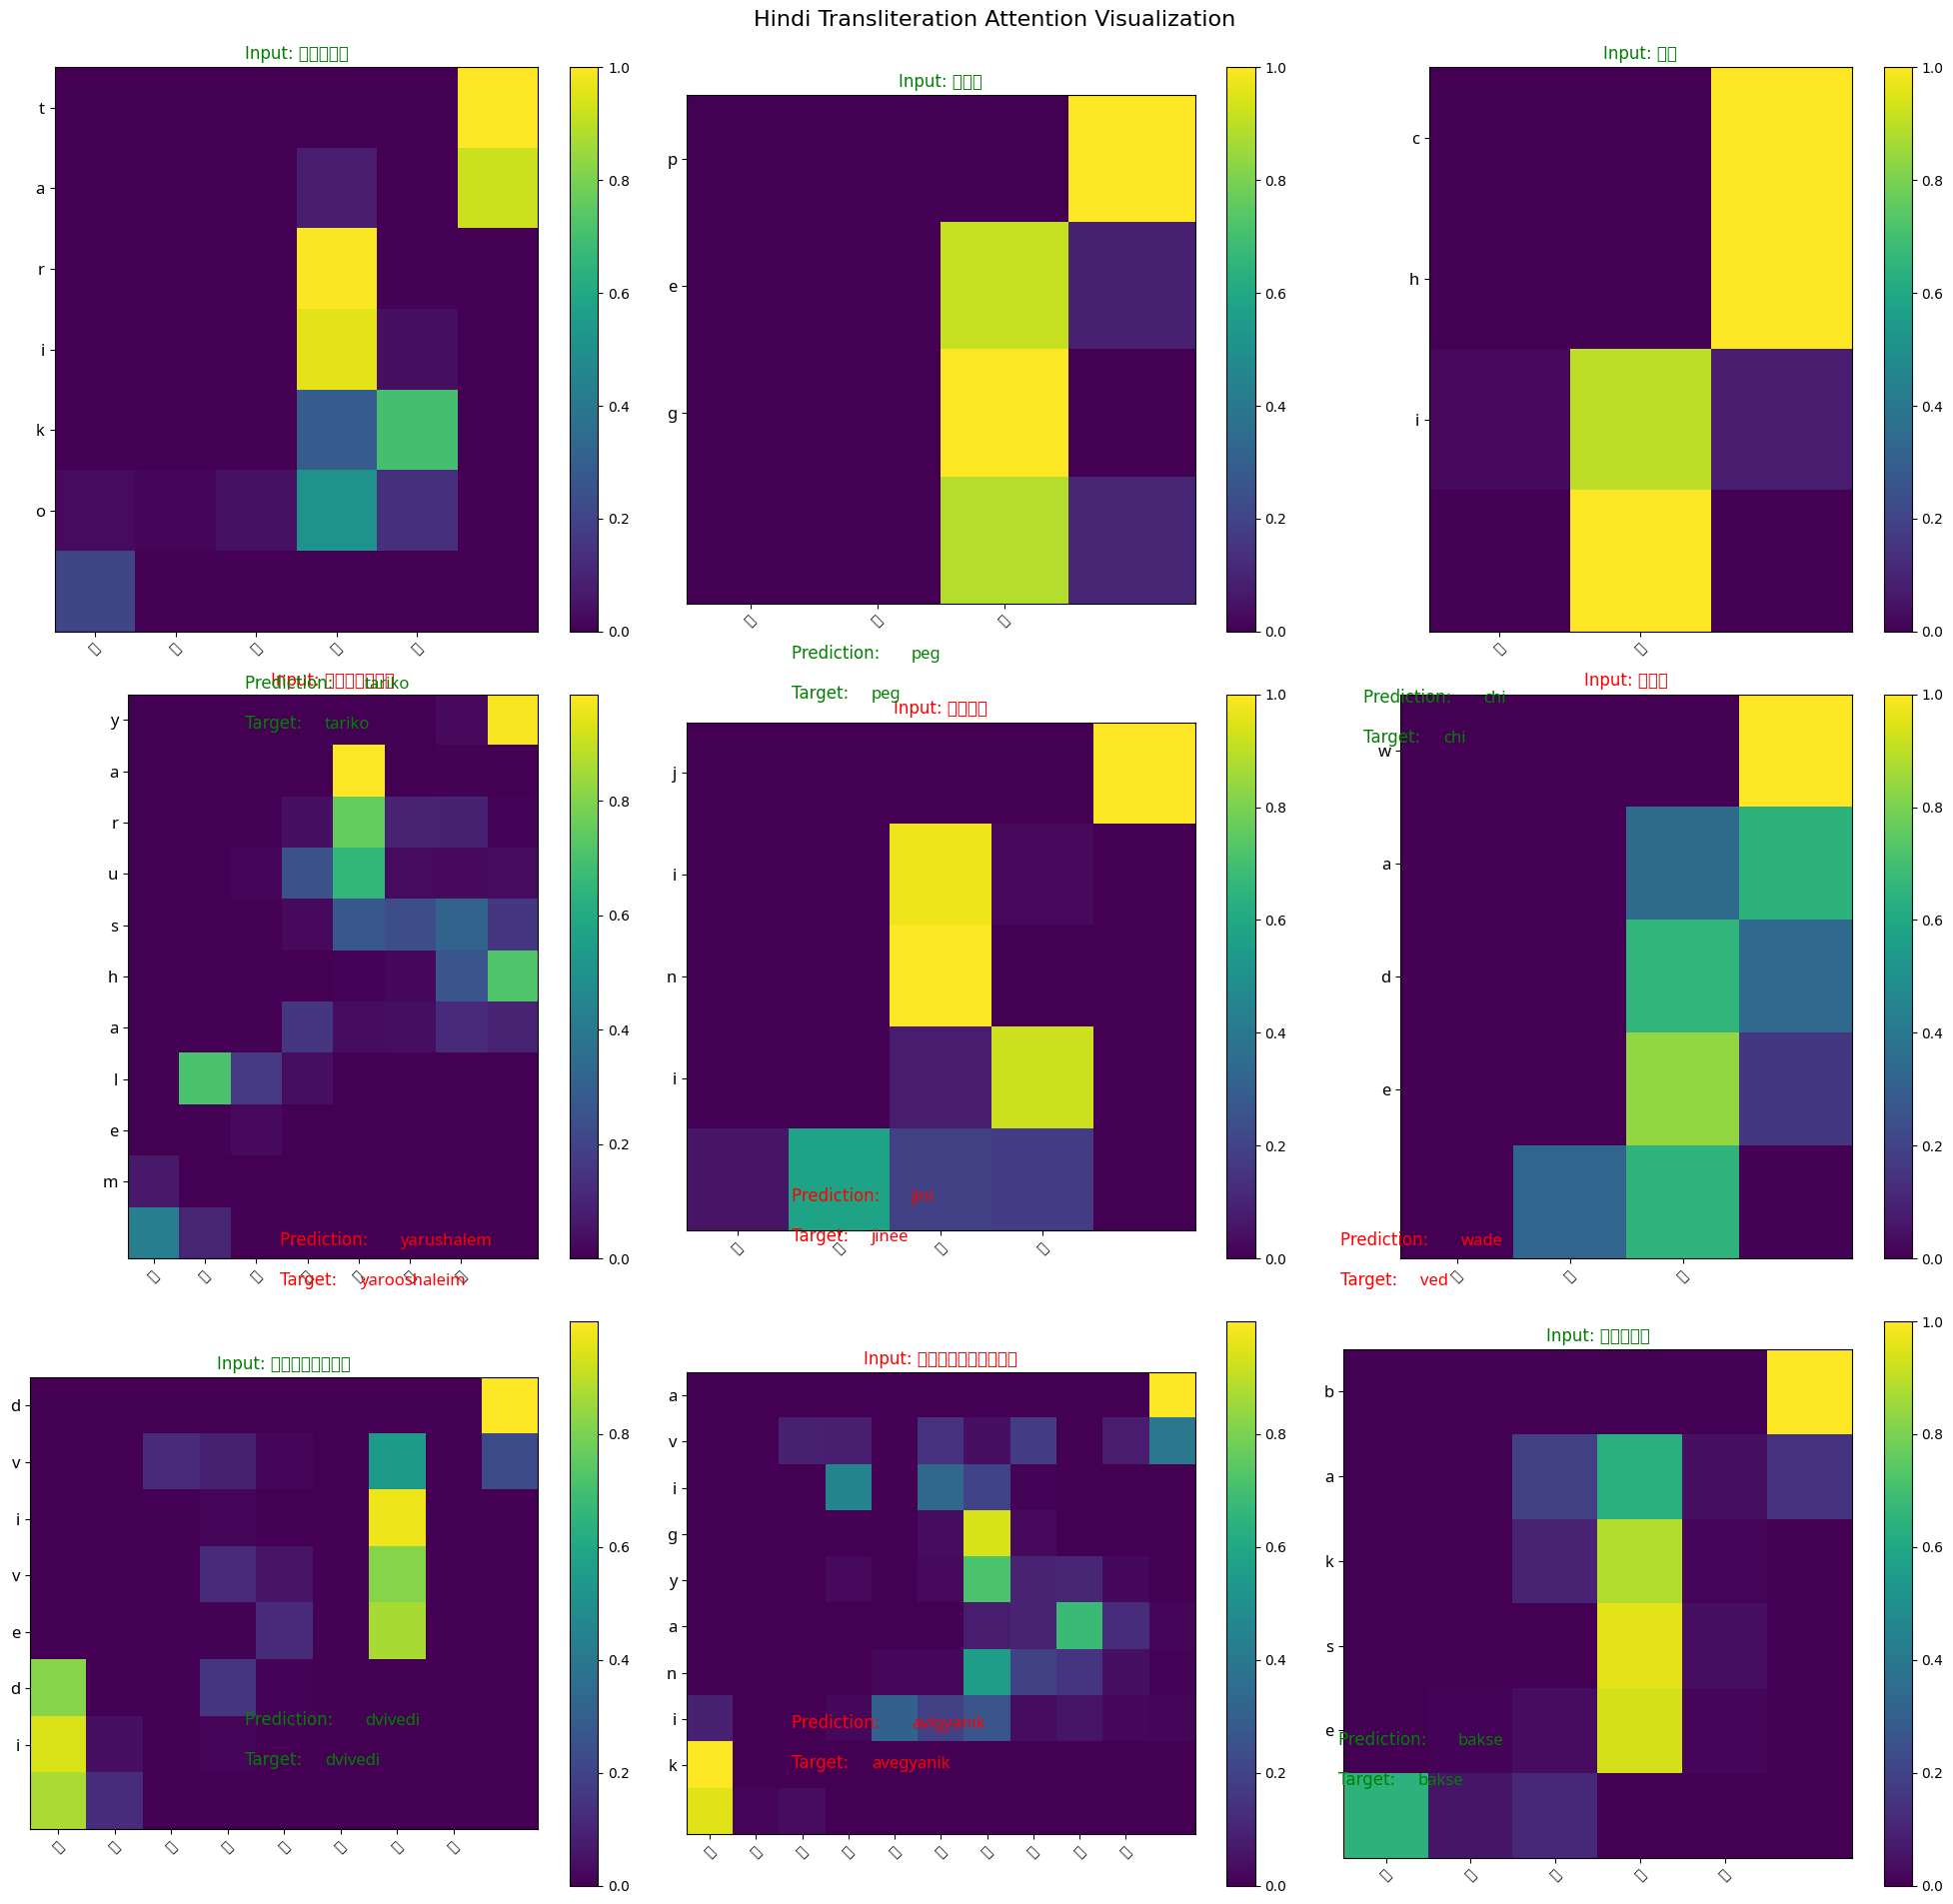

(['akaapulko',
  'akaapulko',
  'angreji',
  'angreji',
  'angreji',
  'antrmukh',
  'antrmukh',
  'antrmukh',
  'andrabi',
  'andrabi',
  'augstin',
  'augstin',
  'achivement',
  'achivement',
  'atthaas',
  'atthaas',
  'angarak',
  'angarak',
  'andhapan',
  'andheri',
  'ambani',
  'ambani',
  'agasta',
  'agasta',
  'agasta',
  'achyut',
  'achhnera',
  'achhnera',
  'ajmidh',
  'agyaat',
  'agyaat',
  'agyaat',
  'ankit',
  'ankon',
  'ankon',
  'ankon',
  'ankor',
  'ankor',
  'agavai',
  'agavai',
  'achambha',
  'achambha',
  'achhi',
  'achhi',
  'achhi',
  'atkata',
  'atkata',
  'atwal',
  'atwal',
  'antah',
  'antah',
  'andha',
  'akaram',
  'akhand',
  'akhil',
  'agra',
  'agra',
  'ajahar',
  'ajahar',
  'ajit',
  'atke',
  'atke',
  'ank',
  'ank',
  'aparivarthanshil',
  'aparivarthanshil',
  'aparivarthanshil',
  'anishvarwadi',
  'anishvarwadi',
  'anuproyogon',
  'anuproyogon',
  'anuproyogon',
  'advaitvad',
  'advaitvad',
  'apariharya',
  'apariharya',
  'apa

In [36]:
# Call the function to evaluate the attention model
evaluate_attention_model()

# Question 6

In [65]:
from tqdm import tqdm

def html_print(s):
    """Create HTML string for display"""
    return f'<pre>{s}</pre>'

def cstr(s, color='black'):
    """Color a string for HTML display"""
    if s == ' ':
        return f'<span style="color:{color}">{s}</span>'
    else:
        return f'<span style="color:{color}; font-weight:bold">{s}</span>'

def print_color(t):
    """Display colored text"""
    display(HTML(html_print(''.join([cstr(ti, color=ci) for ti, ci in t]))))

def get_clr(value):
    """Get color based on attention weight value"""
    # Define a color gradient from white to red
    colors = [
        '#FFFFFF', '#FFFFFF', '#FFFFFF', '#FFFFFF', 
        '#f9e8e8', '#f9e8e8', '#f9d4d4', '#f9bdbd', 
        '#f8a8a8', '#f68f8f', '#f68f8f', '#f47676', 
        '#f45f5f', '#f45f5f', '#f34343', '#f34343', 
        '#f33b3b', '#f33b3b', '#f33b3b', '#f42e2e', '#f42e2e'
    ]
    value = int((value * 100) / 5)  # Scale value to match color array indices
    return colors[min(value, len(colors)-1)]

def save_attention_visualization(model, dataloader, output_vocab, num_samples=5, save_path='attention_visualization.png'):
    """
    Create and save a visualization of attention weights for selected samples.
    Shows which input characters the model is focusing on when decoding each output character.
    """
    model.eval()
    
    # Get samples from the dataloader
    batch = next(iter(dataloader))
    src = batch['input']
    trg = batch['output']
    src_lengths = batch['input_lengths']
    native = batch['native']
    romanized = batch['romanized']
    
    # Limit to num_samples
    src = src[:num_samples]
    trg = trg[:num_samples]
    src_lengths = src_lengths[:num_samples]
    native = native[:num_samples]
    romanized = romanized[:num_samples]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 4 * num_samples))
    gs = gridspec.GridSpec(num_samples, 2, width_ratios=[2, 1])
    
    with torch.no_grad():
        for sample_idx in range(num_samples):
            # Get single sample
            src_item = src[sample_idx:sample_idx+1]
            src_length = src_lengths[sample_idx:sample_idx+1]
            input_text = romanized[sample_idx]
            target_text = native[sample_idx]
            
            # Encode
            encoder_outputs, hidden = model.encoder(src_item, src_length)
            
            # Initialize decoder with SOS token
            decoder_input = torch.tensor([[output_vocab.SOS_token]], device=device)
            
            # Store outputs and attention weights
            outputs = []
            attn_weights = []
            
            # Decode step by step
            for _ in range(100):  # Maximum length
                # Get output and attention weights
                output, hidden, attention = model.decoder(decoder_input, hidden, encoder_outputs)
                
                # Get most likely token
                topv, topi = output.topk(1)
                decoder_input = topi.detach()
                
                # Break if EOS token
                if topi.item() == output_vocab.EOS_token:
                    break
                
                # Store output and attention weights
                outputs.append(output_vocab.idx2char[topi.item()])
                attn_weights.append(attention.squeeze().cpu().numpy())
            
            # Convert attention weights to numpy array
            if attn_weights:
                attn_weights = np.array(attn_weights)
                
                # Create heatmap subplot
                ax1 = plt.subplot(gs[sample_idx, 0])
                im = ax1.imshow(attn_weights, cmap='Blues', aspect='auto')
                
                # Set labels
                ax1.set_xticks(range(len(input_text)))
                ax1.set_xticklabels(list(input_text), rotation=45, fontproperties=hindi_font)
                ax1.set_yticks(range(len(outputs)))
                ax1.set_yticklabels(outputs)
                
                # Add title
                pred_text = ''.join(outputs)
                is_correct = pred_text == target_text
                title_color = 'green' if is_correct else 'red'
                ax1.set_title(f"Sample {sample_idx+1}: Input: '{input_text}' → Pred: '{pred_text}' (Target: '{target_text}')", 
                             color=title_color, fontproperties=hindi_font)
                
                ax1.set_xlabel("Input characters")
                ax1.set_ylabel("Output characters")
                
                # Add colorbar
                plt.colorbar(im, ax=ax1)
                
                # Create connectivity visualization subplot
                ax2 = plt.subplot(gs[sample_idx, 1])
                
                # Calculate maximum attention weight for each output character
                max_attn_indices = np.argmax(attn_weights, axis=1)
                
                # Plot input text
                for i, char in enumerate(input_text):
                    ax2.text(0, i, char, ha='center', va='center', fontsize=12, 
                             bbox=dict(facecolor='lightblue', alpha=0.3), fontproperties=hindi_font)
                
                # Plot output text
                for i, char in enumerate(outputs):
                    ax2.text(2, i, char, ha='center', va='center', fontsize=12,
                            bbox=dict(facecolor='lightgreen', alpha=0.3))
                    
                    # Connect output to input with highest attention weight
                    max_idx = max_attn_indices[i]
                    # Scale line width based on attention weight
                    linewidth = 2.0 * attn_weights[i, max_idx]
                    ax2.plot([0.5, 1.5], [max_idx, i], 'r-', linewidth=linewidth, alpha=0.7)
                
                ax2.set_xlim(-0.5, 2.5)
                ax2.set_ylim(-0.5, max(len(input_text), len(outputs)) - 0.5)
                ax2.axis('off')
                
    plt.tight_layout()
    plt.savefig(save_path)
    return fig

def interactive_attention_visualization(model, dataloader, output_vocab, index=0):
    """
    Create an interactive visualization that shows the attention weights
    as each character is generated.
    """
    model.eval()
    
    # Get a batch from the dataloader
    all_batches = list(dataloader)
    batch = all_batches[index // 64]  # Assuming batch size of 64
    idx_in_batch = index % 64
    
    src = batch['input'][idx_in_batch:idx_in_batch+1]
    src_lengths = batch['input_lengths'][idx_in_batch:idx_in_batch+1]
    input_text = batch['romanized'][idx_in_batch]
    target_text = batch['native'][idx_in_batch]
    
    with torch.no_grad():
        # Encode
        encoder_outputs, hidden = model.encoder(src, src_lengths)
        
        # Initialize decoder with SOS token
        decoder_input = torch.tensor([[output_vocab.SOS_token]], device=device)
        
        # Store outputs and attention weights
        outputs = []
        all_attn_weights = []
        
        # Decode step by step
        for _ in range(100):  # Maximum length
            # Get output and attention weights
            output, hidden, attention = model.decoder(decoder_input, hidden, encoder_outputs)
            
            # Get most likely token
            topv, topi = output.topk(1)
            decoder_input = topi.detach()
            
            # Break if EOS token
            if topi.item() == output_vocab.EOS_token:
                break
            
            # Store output and attention weights
            outputs.append(output_vocab.idx2char[topi.item()])
            all_attn_weights.append(attention.squeeze().cpu().numpy()[:src_lengths.item()])
    
    # Define the visualization function
    def visualization(attn_weights, outputs, input_text):
        # Create identity matrix for output highlighting
        eng_wts = np.identity(len(outputs))
        eng_wts *= np.max([np.max(attn_weights[i]) for i in range(len(attn_weights))])
        
        for i in range(len(attn_weights)):
            # Prepare colored text for output
            text_output = []
            for j in range(len(outputs)):
                weight = eng_wts[i][j] if j < len(eng_wts) and i < len(eng_wts[j]) else 0
                text_output.append((outputs[j], get_clr(weight)))
            
            # Prepare colored text for input
            text_input = []
            for j in range(len(input_text)):
                weight = attn_weights[i][j] if j < len(attn_weights[i]) else 0
                text_input.append((input_text[j], get_clr(weight)))
            
            print(f"Decoding step {i+1}: Output character '{outputs[i]}'")
            print_color(text_output)  # Display highlighted output characters
            print_color(text_input)   # Display highlighted input characters
            print("\n")
            time.sleep(1)  # Add delay for animation effect
    
    # Run visualization
    visualization(all_attn_weights, outputs, input_text)
    
    # Display final result
    pred_text = ''.join(outputs)
    is_correct = pred_text == target_text
    result_color = 'green' if is_correct else 'red'
    print(f"Final result: Input: '{input_text}' → Predicted: '{pred_text}' (Target: '{target_text}')")
    
    return pred_text, all_attn_weights

def generate_attention_connectivity_visualization(predictions, targets, inputs, attentions, n_samples=5):
    """
    Generate a visualization showing the connectivity between input and output characters
    based on attention weights.
    """
    # Select random samples
    indices = random.sample(range(len(predictions)), min(n_samples, len(predictions)))
    
    # Create figure
    fig, axes = plt.subplots(n_samples, 1, figsize=(12, 5 * n_samples))
    if n_samples == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        
        # Get data
        input_text = inputs[idx]
        pred_text = predictions[idx]
        target_text = targets[idx]
        attention = attentions[idx]
        
        # Determine maximum attention for each output character
        max_attention_indices = np.argmax(attention, axis=1)
        
        # Plot input characters
        for j, char in enumerate(input_text):
            ax.text(j, 0, char, ha='center', va='center', fontsize=12, 
                   bbox=dict(facecolor='lightblue', alpha=0.3))
        
        # Plot output characters
        for j, char in enumerate(pred_text):
            ax.text(j, 1, char, ha='center', va='center', fontsize=12,
                  bbox=dict(facecolor='lightgreen', alpha=0.3))
            
            # Draw connection line based on attention
            if j < len(max_attention_indices):
                max_idx = max_attention_indices[j]
                attn_value = attention[j, max_idx]
                # Scale line width by attention value
                linewidth = max(0.5, 3.0 * attn_value)
                ax.plot([max_idx, j], [0.15, 0.85], 'r-', alpha=0.7, linewidth=linewidth)
        
        # Set title
        is_correct = pred_text == target_text
        title_color = 'green' if is_correct else 'red'
        ax.set_title(f"Sample {i+1}: Input: '{input_text}' → Pred: '{pred_text}' (Target: '{target_text}')", 
                     color=title_color)
        
        # Set axis limits
        ax.set_xlim(-0.5, max(len(input_text), len(pred_text)))
        ax.set_ylim(-0.5, 1.5)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_connectivity.png')
    wandb.log({"attention_connectivity": wandb.Image('attention_connectivity.png')})
    
    return fig

# Function to integrate the visualization into the evaluation workflow
def evaluate_attention_model_with_visualization():
    # Set up Weights & Biases for logging
    run = wandb.init(project='hindi-transliteration_connection', name='attention-model-visualization', job_type='evaluation')

    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')

    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')

    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

    # Load the best hyperparameters
    best_params = {
        'embed_size': 256,
        'hidden_size': 512,
        'num_layers': 2,
        'cell_type': 'LSTM',
        'dropout': 0.2,
        'beam_size': 3
    }
    

    # Create model with best parameters
    input_size = len(input_vocab)
    output_size = len(output_vocab)

    encoder = Encoder(input_size, best_params['embed_size'], best_params['hidden_size'],
                     best_params['num_layers'], best_params['dropout'], best_params['cell_type'])
    attention_decoder = AttentionDecoder(output_size, best_params['embed_size'], best_params['hidden_size'],
                                        best_params['num_layers'], best_params['dropout'], best_params['cell_type'])
    model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)

    # Load best model weights
    model.load_state_dict(torch.load('best_attention_model.pt'))

    # Test the model and get attention weights
    predictions, targets, inputs, attentions, char_acc, word_acc = test_model_with_attention(
        model, test_dataloader, output_vocab, beam_size=best_params['beam_size'])

    # Log test metrics to WandB
    wandb.log({
        'test_char_accuracy': char_acc,
        'test_word_accuracy': word_acc
    })

    print(f'Character-level accuracy: {char_acc:.4f}')
    print(f'Word-level accuracy: {word_acc:.4f}')

    # Create static visualization of attention patterns
    save_attention_visualization(model, test_dataloader, output_vocab, num_samples=5)
    wandb.log({"attention_visualization": wandb.Image('attention_visualization.png')})

    # Create connectivity visualization showing which input character influences which output character
    generate_attention_connectivity_visualization(predictions, targets, inputs, attentions, n_samples=5)

    # Select a specific example for detailed analysis
    sample_idx = random.randint(0, len(predictions)-1)
    print(f"\nDetailed analysis of sample {sample_idx}:")
    print(f"Input: '{inputs[sample_idx]}'")
    print(f"Prediction: '{predictions[sample_idx]}'")
    print(f"Target: '{targets[sample_idx]}'")
    
    # Create an attention heatmap for this specific example
    plt.figure(figsize=(10, 6))
    plt.imshow(attentions[sample_idx], cmap='Blues')
    plt.colorbar()
    plt.xticks(range(len(inputs[sample_idx])), list(inputs[sample_idx]), rotation=45)
    plt.yticks(range(len(predictions[sample_idx])), list(predictions[sample_idx]))
    plt.xlabel('Input characters')
    plt.ylabel('Output characters')
    plt.title(f"Attention weights for transliterating '{inputs[sample_idx]}'")
    plt.tight_layout()
    plt.savefig('sample_attention_heatmap.png')
    wandb.log({"sample_attention_heatmap": wandb.Image('sample_attention_heatmap.png')})

    return predictions, targets, inputs, attentions

In [66]:
def evaluate_with_config():
    # Initialize W&B run with config from sweep
    run = wandb.init(project='hindi-transliteration_connection', name='attention-model-visualization', job_type='evaluation')
    
    # Instead of using sweep config parameters, let's use the parameters from the saved model
    # These should match the parameters used during training
    params = {
        'embed_size': 64,      # Change from 256 to 64 to match saved model
        'hidden_size': 512,    # Keep as is
        'num_layers': 2,       # Keep as is  
        'cell_type': 'LSTM',   # Keep as is
        'dropout': 0.2,        # Keep as is
        'beam_size': 3         # Keep as is
    }
    
    # Log the actual parameters being used
    for key, value in params.items():
        wandb.config[key] = value

    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')

    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')

    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

    # Create model with parameters from config
    input_size = len(input_vocab)
    output_size = len(output_vocab)

    encoder = Encoder(input_size, params['embed_size'], params['hidden_size'],
                      params['num_layers'], params['dropout'], params['cell_type'])
    attention_decoder = AttentionDecoder(output_size, params['embed_size'], params['hidden_size'],
                                         params['num_layers'], params['dropout'], params['cell_type'])
    model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)

    # Load best model weights
    model.load_state_dict(torch.load('best_attention_model.pt'))

    # Test the model and get predictions
    print("Testing model...")
    predictions, targets, inputs, char_acc, word_acc = test_model(
        model, test_dataloader, output_vocab, beam_size=params['beam_size'])

    # Log test metrics
    wandb.log({
        'char_level_accuracy': char_acc,
        'word_level_accuracy': word_acc
    })
    
    print(f'Character-level accuracy: {char_acc:.4f}')
    print(f'Word-level accuracy: {word_acc:.4f}')

    # Create static visualization showing attention weights
    # We need a test_model_with_attention function to get attention weights
    # Since we don't have one defined, let's use what we have
    
    # Create visualization of attention patterns
    fig = save_attention_visualization(model, test_dataloader, output_vocab, num_samples=5)
    wandb.log({"attention_visualization": wandb.Image(fig)})
    
    # Select a specific example for detailed analysis
    sample_idx = random.randint(0, len(predictions)-1)
    print(f"\nDetailed analysis of sample {sample_idx}:")
    print(f"Input: '{inputs[sample_idx]}'")
    print(f"Prediction: '{predictions[sample_idx]}'")
    print(f"Target: '{targets[sample_idx]}'")

    return predictions, targets, inputs

In [67]:
def evaluate_attention_model_with_visualization():
    # Define sweep configuration with fixed parameters to match the saved model
    wandb.login(key="86398b520e35649f62ef0fe78a5f8cec01b76d3f")
    sweep_config = {
        "method": "grid",  # Use grid to ensure we only use the specified parameters
        "metric": {"goal": "minimize", "name": "loss"},
        "parameters": {
            "embed_size": {"values": [64]},  # Change from 256 to 64 to match saved model
            "hidden_size": {"values": [512]},
            "num_layers": {"values": [2]},
            "dropout": {"values": [0.2]},
            "beam_size": {"values": [3]},
            "cell_type": {"values": ["LSTM"]}
        }
    }

    # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project='hindi-transliteration_connection')

    # Start the sweep agent with count=1 to run only once
    wandb.agent(sweep_id, function=evaluate_with_config, count=1)

In [68]:
import os
import requests
from matplotlib import font_manager as fm

# Define target directory and font file path
font_dir = os.path.expanduser("~/.fonts")
os.makedirs(font_dir, exist_ok=True)
font_file = os.path.join(font_dir, "NotoSansDevanagari.ttf")

# Download and save the font
url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
with requests.get(url) as resp:
    with open(font_file, "wb") as f:
        f.write(resp.content)

# Clear cached fonts and register the new font
os.system("rm -rf ~/.cache/matplotlib")
fm.fontManager.addfont(font_file)
hindi_font = fm.FontProperties(fname=font_file)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: vqi14r3j
Sweep URL: https://wandb.ai/da24m004-iitmaana/hindi-transliteration_connection/sweeps/vqi14r3j


wandb: Agent Starting Run: ssuqvxtf with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 64
wandb: 	hidden_size: 512
wandb: 	num_layers: 2


wandb: WARNING Config item 'embed_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'hidden_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cell_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'beam_size' was locked by 'sweep' (ignored update).


Dataset prepared for language: hi
Testing model...


100%|██████████| 71/71 [10:08<00:00,  8.57s/it]


Character-level accuracy: 0.7204
Word-level accuracy: 0.4209


/tmp/ipykernel_35/1596738733.py:145: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/1596738733.py:146: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  plt.savefig(save_path)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)



Detailed analysis of sample 3876:
Input: 'वेस्ले'
Prediction: 'vesle'
Target: 'vesle'


char_level_accuracy,▁
word_level_accuracy,▁
char_level_accuracy,0.72042
word_level_accuracy,0.42092


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


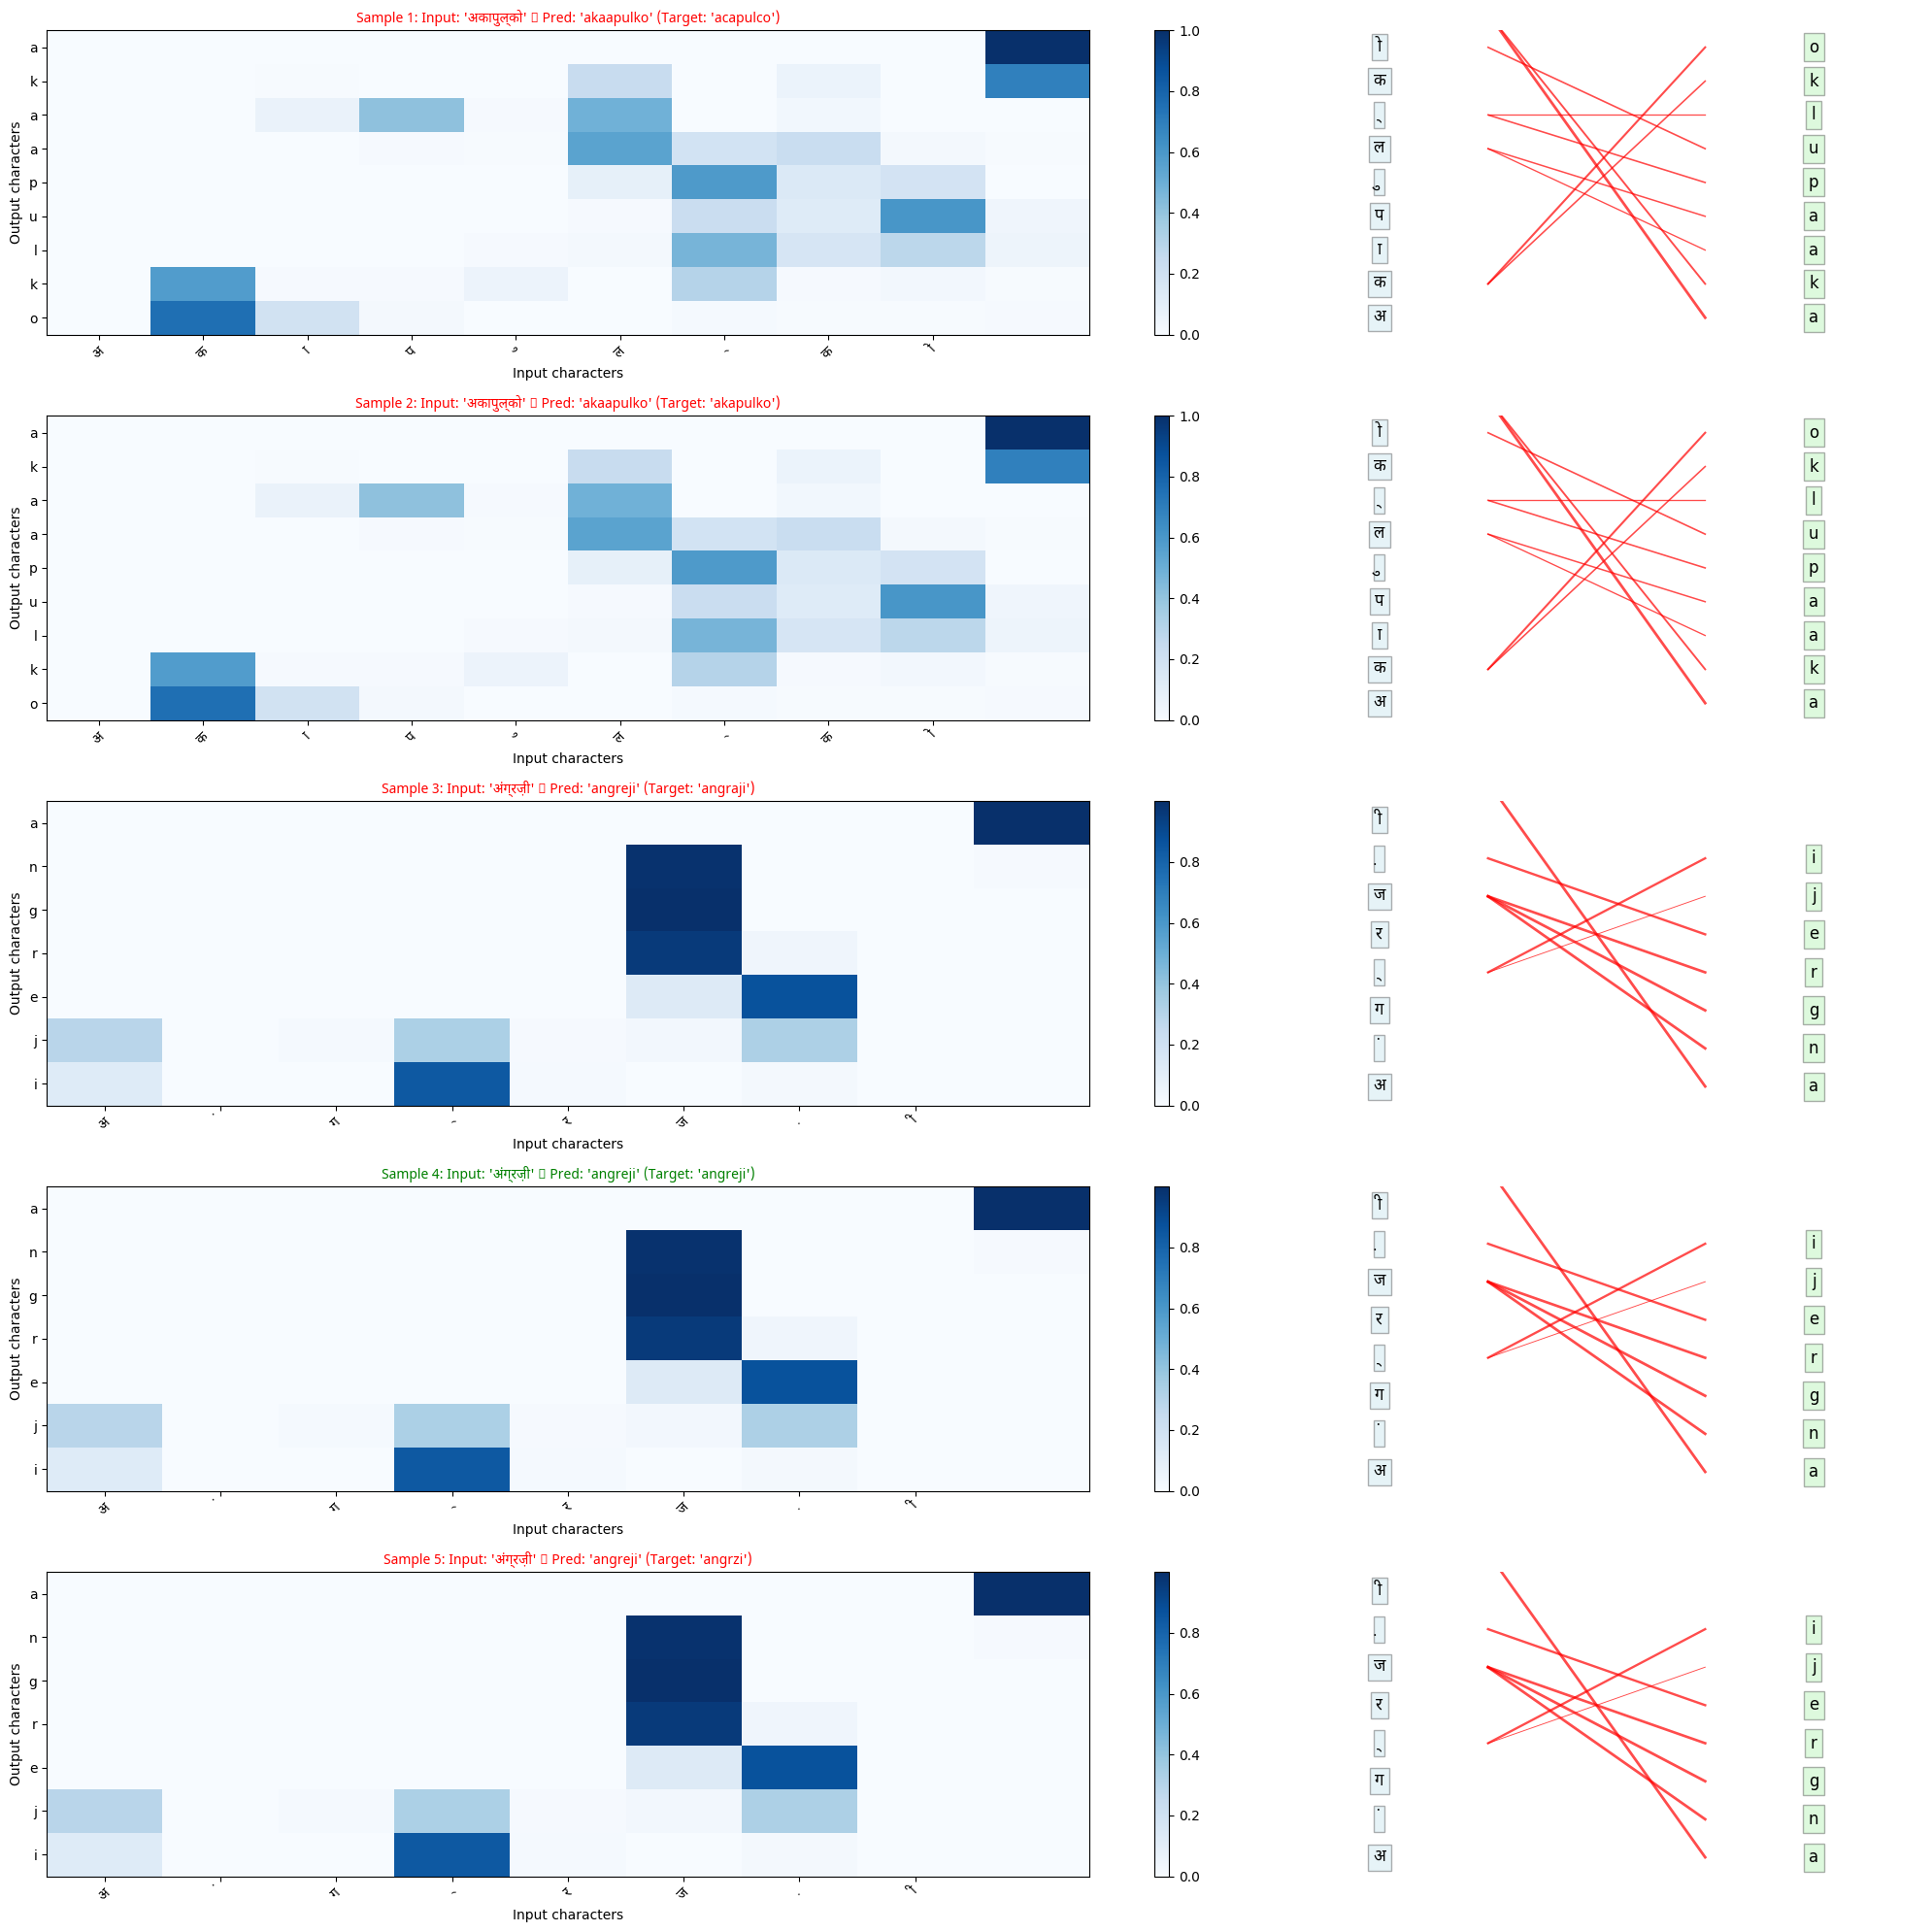

In [69]:
evaluate_attention_model_with_visualization()

In [59]:
import os
import requests
from matplotlib import font_manager as fm
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'sans-serif']

# Define target directory and font file path
font_dir = os.path.expanduser("~/.fonts")
os.makedirs(font_dir, exist_ok=True)
font_file = os.path.join(font_dir, "NotoSansDevanagari.ttf")

# Download and save the font
url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
with requests.get(url) as resp:
    with open(font_file, "wb") as f:
        f.write(resp.content)

# Clear cached fonts and register the new font
os.system("rm -rf ~/.cache/matplotlib")
fm.fontManager.addfont(font_file)
hindi_font = fm.FontProperties(fname=font_file)


In [72]:
# Setup your model, data, and vocabularies first
def run_interactive_visualization():
    # Load model and data
    params = {
        'embed_size': 64,      # Change from 256 to 64 to match saved model
        'hidden_size': 512,    # Keep as is
        'num_layers': 2,       # Keep as is  
        'cell_type': 'LSTM',   # Keep as is
        'dropout': 0.2,        # Keep as is
        'beam_size': 3         # Keep as is
    }
    
    # Log the actual parameters being used
    # for key, value in params.items():
    #     wandb.config[key] = value

    # Download and prepare the dataset
    data_path = download_and_prepare_dataset(language='hi')

    # Load the datasets
    romanized_train, native_train = load_dataset(data_path, 'train')
    romanized_test, native_test = load_dataset(data_path, 'test')

    # Create vocabularies
    input_vocab, output_vocab = create_vocabs(romanized_train, native_train)

    # Create test dataset
    test_dataset = TransliterationDataset(romanized_test, native_test, input_vocab, output_vocab)

    # Create dataloader
    test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

    # Create model with parameters from config
    input_size = len(input_vocab)
    output_size = len(output_vocab)

    encoder = Encoder(input_size, params['embed_size'], params['hidden_size'],
                      params['num_layers'], params['dropout'], params['cell_type'])
    attention_decoder = AttentionDecoder(output_size, params['embed_size'], params['hidden_size'],
                                         params['num_layers'], params['dropout'], params['cell_type'])
    model = Seq2SeqAttention(encoder, attention_decoder, device).to(device)

    # Load best model weights
    model.load_state_dict(torch.load('best_attention_model.pt'))
    
    # Pick a random index to visualize
    random_index = random.randint(0, len(test_dataset) - 1)
    print(f"Visualizing example at index {random_index}")
    
    # Run the interactive visualization
    pred_text, attention_weights = interactive_attention_visualization(
        model=model,
        dataloader=test_dataloader,
        output_vocab=output_vocab,
        index=random_index
    )
    
    # You can further analyze the attention weights if needed
    print("Attention weights shape:", attention_weights[0].shape)
    
    # Optionally save a static visualization of the same example
    plt.figure(figsize=(10, 6))
    plt.imshow(np.array(attention_weights), cmap='Blues')
    plt.colorbar()
    plt.xlabel('Input characters')
    plt.ylabel('Output characters')
    plt.title(f"Complete attention map for example {random_index}")
    plt.savefig(f"attention_example_{random_index}.png")
    plt.close()

# Call the function to run the visualization
run_interactive_visualization()

Dataset prepared for language: hi
Visualizing example at index 110
Decoding step 1: Output character 'a'




Decoding step 2: Output character 't'




Decoding step 3: Output character 'h'




Decoding step 4: Output character 'a'




Decoding step 5: Output character 'r'




Decoding step 6: Output character 'v'




Final result: Input: 'अथर्व' → Predicted: 'atharv' (Target: 'atharv')
Attention weights shape: (6,)
